In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X.loc[fraud_index]
honest = X.loc[honest_index]

In [4]:
yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [5]:
h_train, h_test, hy_train, hy_test = train_test_split(honest, yh,test_size=0.4,random_state=30)
h_train, h_test, hy_train, hy_test = train_test_split(h_test, hy_test,test_size=0.3,random_state=30)
h_test, h_val, hy_test, hy_val = train_test_split(h_test, hy_test,test_size=0.5,random_state=30)

In [6]:
f_train, f_test, fy_train, fy_test = train_test_split(fraud, yf,test_size=0.3,random_state=30)
f_test, f_val, fy_test, fy_val = train_test_split(f_test, fy_test,test_size=0.5,random_state=30)

In [7]:
len(h_train)/len(f_train)

3.580608473130509

In [8]:
x_train = pd.concat([h_train,f_train],ignore_index = True)
x_test = pd.concat([h_test,f_test],ignore_index = True)
x_val = pd.concat([h_val,f_val],ignore_index = True)

y_train = pd.concat([hy_train,fy_train],ignore_index = True)
y_test = pd.concat([hy_test,fy_test],ignore_index = True)
y_val = pd.concat([hy_val,fy_val],ignore_index = True)

In [9]:
meanx = x_train.mean(axis = 0)
stdx = x_train.std(axis = 0)
x_train_norm = (x_train - meanx)/stdx
x_val_norm = (x_val - meanx)/stdx
x_test_norm = (x_test - meanx)/stdx
x_train_norm=np.asarray(x_train_norm)
x_test_norm=np.asarray(x_test_norm)
x_val_norm=np.asarray(x_val_norm)

In [10]:
import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [11]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

In [12]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [13]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [15]:
class new_rna:
    def build_model(self,data_shape,units_list,activation_list,dropout_list):
        self.model = models.Sequential()
        if len(dropout_list)<0:
            my_init = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i], 
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i]))
        else:
            my_init = keras.initializers.RandomUniform(minval=-0.05, 
                                                       maxval=0.05, 
                                                       seed=1)
            for i in range(len(units_list)):
                if i == 0:
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i],
                                                kernel_initializer = my_init,
                                                input_shape=data_shape))
                else:
                    self.model.add(layers.Dropout(dropout_list[i-1]))
                    self.model.add(layers.Dense(units=units_list[i], 
                                                activation=activation_list[i]))
        self.model.summary()
           
    def train(self,x_train,y_train,x_val,y_val,batch_size,epochs,loss,metric):
        mom = optimizers.SGD(lr=0.001, decay=0, momentum=0.9, nesterov=True)
        self.model.compile(loss = [loss],metrics = [metric], optimizer = mom)
        history = self.model.fit(x_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (x_val,y_val))
        self.history_dict = history.history
        self.aux_train = 1
        
    def plot(self):
        if (self.aux_train == 1):
            self.aux_plt = 1
            cost = self.history_dict['loss']
            metric = self.history_dict['f1']
            val_cost = self.history_dict['val_loss']
            val_metric = self.history_dict['val_f1']
            aux_epocas = range(1,len(cost)+1)
            plt.plot(aux_epocas,cost,'b',label = 'Custo - treinamento', color = 'red')
            plt.plot(aux_epocas,val_cost,'b',label = 'Custo - validacao', color = 'blue')
            plt.title(' Valor da Funcao Custo = Treinamento e Validacao')
            plt.xlabel('Épocas')
            plt.ylabel('Custo')
            plt.legend()
            plt.show()
            plt.plot(aux_epocas, metric,'b',label = 'metrica - treinamento',color = 'red')
            plt.plot(aux_epocas, val_metric,'b',label = 'metrica - validacao', color = 'blue')
            plt.title('Valor da métrica – treinamento e validação')
            plt.xlabel('Épocas')
            plt.ylabel('Acertividade')
            plt.legend()
            plt.show()
        else:
            print('Train before plot')

    def predict(self,x_data,y_data):
        if (self.aux_plt == 1):
            class_names = np.array([['Honest'],['Fraud']])
            subtitle = ['Test', 'Val', 'Train']
            for i in range(len(x_data)):
                y_hat = self.model.predict(x_data[i])
                yy_hat = np.round(y_hat)
                yy_hat = yy_hat.astype(int)
                yy_hat = np.ravel(yy_hat)
                f1 = f1_score(y_data[i],yy_hat)
                plot_confusion_matrix(np.int_(y_data[i]), np.int_(yy_hat), classes=class_names,
                                      title='F1_Score = {0}: {1} Data'.format(f1, subtitle[i]))
                plt.show()
            K.clear_session()
        else:
            print('Train before predict')

In [16]:
data_shape = (200,)

loss = 'binary_crossentropy'
metric = f1
batch_size = 32
epochs = 2000

x_data = [x_test_norm,x_val_norm,x_train_norm]
y_data = [y_test,y_val,y_train]

In [17]:
n_list0 = [50,1]
activation_list0 = ['tanh','sigmoid']
dropout_list0 = [0.3]

In [18]:
rna0 = new_rna()
rna0.build_model(data_shape,n_list0,activation_list0,dropout_list0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,101
Trainable params: 10,101
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 64440 samples, validate on 13810 samples
Epoch 1/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.4001 - f1: 0.5105 - val_loss: 0.3695 - val_f1: 0.1395
Epoch 2/2000
64440/64440 [==============================] - 2s 30us/step - loss: 0.3693 - f1: 0.5425 - val_loss: 0.3681 - val_f1: 0.1427
Epoch 3/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3681 - f1: 0.5455 - val_loss: 0.3680 - val_f1: 0.1421
Epoch 4/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3658 - f1: 0.5482 - val_loss: 0.3671 - val_f1: 0.1413
Epoch 5/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3655 - f1: 0.5461 - val_loss: 0.3664 - val_f1: 0.1425
Epoch 6/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.3645 - f1: 0.5471 - val_loss: 0.3670 - val_f1: 0.1405
Epoch 7/2000
64440/64440 [==============================] - 2s 31us/step - loss:

64440/64440 [==============================] - 2s 33us/step - loss: 0.3549 - f1: 0.5640 - val_loss: 0.3672 - val_f1: 0.1427
Epoch 59/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3546 - f1: 0.5604 - val_loss: 0.3674 - val_f1: 0.1428
Epoch 60/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3537 - f1: 0.5598 - val_loss: 0.3675 - val_f1: 0.1427
Epoch 61/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3538 - f1: 0.5648 - val_loss: 0.3675 - val_f1: 0.1444
Epoch 62/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3547 - f1: 0.5620 - val_loss: 0.3672 - val_f1: 0.1434
Epoch 63/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3546 - f1: 0.5639 - val_loss: 0.3672 - val_f1: 0.1417
Epoch 64/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3538 - f1: 0.5635 - val_loss: 0.3673 - val_f1: 0.1424
Epoch 65/2000
64440/64440 [=====================

64440/64440 [==============================] - 2s 34us/step - loss: 0.3398 - f1: 0.5832 - val_loss: 0.3702 - val_f1: 0.1417
Epoch 118/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.3404 - f1: 0.5823 - val_loss: 0.3713 - val_f1: 0.1419
Epoch 119/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.3412 - f1: 0.5822 - val_loss: 0.3703 - val_f1: 0.1425
Epoch 120/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3411 - f1: 0.5820 - val_loss: 0.3705 - val_f1: 0.1424
Epoch 121/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3395 - f1: 0.5907 - val_loss: 0.3710 - val_f1: 0.1414
Epoch 122/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3398 - f1: 0.5871 - val_loss: 0.3705 - val_f1: 0.1419
Epoch 123/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3394 - f1: 0.5845 - val_loss: 0.3709 - val_f1: 0.1408
Epoch 124/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 36us/step - loss: 0.3255 - f1: 0.6117 - val_loss: 0.3769 - val_f1: 0.1427
Epoch 177/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3253 - f1: 0.6091 - val_loss: 0.3765 - val_f1: 0.1410
Epoch 178/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3237 - f1: 0.6138 - val_loss: 0.3765 - val_f1: 0.1416
Epoch 179/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3227 - f1: 0.6156 - val_loss: 0.3772 - val_f1: 0.1425
Epoch 180/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3253 - f1: 0.6153 - val_loss: 0.3774 - val_f1: 0.1416
Epoch 181/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3237 - f1: 0.6110 - val_loss: 0.3766 - val_f1: 0.1409
Epoch 182/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3217 - f1: 0.6150 - val_loss: 0.3784 - val_f1: 0.1413
Epoch 183/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.3112 - f1: 0.6310 - val_loss: 0.3830 - val_f1: 0.1415
Epoch 236/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3125 - f1: 0.6318 - val_loss: 0.3829 - val_f1: 0.1416
Epoch 237/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3121 - f1: 0.6295 - val_loss: 0.3827 - val_f1: 0.1417
Epoch 238/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3113 - f1: 0.6328 - val_loss: 0.3829 - val_f1: 0.1415
Epoch 239/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3093 - f1: 0.6347 - val_loss: 0.3833 - val_f1: 0.1424
Epoch 240/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.3118 - f1: 0.6348 - val_loss: 0.3832 - val_f1: 0.1416
Epoch 241/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3102 - f1: 0.6344 - val_loss: 0.3838 - val_f1: 0.1409
Epoch 242/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.3031 - f1: 0.6415 - val_loss: 0.3887 - val_f1: 0.1421
Epoch 295/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3023 - f1: 0.6504 - val_loss: 0.3883 - val_f1: 0.1406
Epoch 296/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.3035 - f1: 0.6442 - val_loss: 0.3877 - val_f1: 0.1416
Epoch 297/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3024 - f1: 0.6439 - val_loss: 0.3876 - val_f1: 0.1422
Epoch 298/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3030 - f1: 0.6458 - val_loss: 0.3883 - val_f1: 0.1409
Epoch 299/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3031 - f1: 0.6476 - val_loss: 0.3877 - val_f1: 0.1415
Epoch 300/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.3019 - f1: 0.6492 - val_loss: 0.3884 - val_f1: 0.1415
Epoch 301/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 37us/step - loss: 0.2966 - f1: 0.6554 - val_loss: 0.3922 - val_f1: 0.1394
Epoch 354/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2965 - f1: 0.6600 - val_loss: 0.3916 - val_f1: 0.1402
Epoch 355/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2962 - f1: 0.6590 - val_loss: 0.3916 - val_f1: 0.1405
Epoch 356/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2948 - f1: 0.6544 - val_loss: 0.3921 - val_f1: 0.1411
Epoch 357/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2962 - f1: 0.6562 - val_loss: 0.3932 - val_f1: 0.1400
Epoch 358/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2963 - f1: 0.6581 - val_loss: 0.3920 - val_f1: 0.1412
Epoch 359/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2968 - f1: 0.6592 - val_loss: 0.3923 - val_f1: 0.1406
Epoch 360/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2924 - f1: 0.6624 - val_loss: 0.3961 - val_f1: 0.1404
Epoch 413/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2917 - f1: 0.6624 - val_loss: 0.3962 - val_f1: 0.1400
Epoch 414/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2893 - f1: 0.6677 - val_loss: 0.3969 - val_f1: 0.1404
Epoch 415/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2902 - f1: 0.6636 - val_loss: 0.3973 - val_f1: 0.1392
Epoch 416/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2909 - f1: 0.6665 - val_loss: 0.3959 - val_f1: 0.1392
Epoch 417/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2908 - f1: 0.6680 - val_loss: 0.3962 - val_f1: 0.1403
Epoch 418/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2906 - f1: 0.6659 - val_loss: 0.3960 - val_f1: 0.1401
Epoch 419/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2863 - f1: 0.6682 - val_loss: 0.3984 - val_f1: 0.1399
Epoch 472/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2878 - f1: 0.6700 - val_loss: 0.3987 - val_f1: 0.1408
Epoch 473/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2867 - f1: 0.6719 - val_loss: 0.3986 - val_f1: 0.1406
Epoch 474/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2870 - f1: 0.6728 - val_loss: 0.3992 - val_f1: 0.1399
Epoch 475/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2886 - f1: 0.6690 - val_loss: 0.3996 - val_f1: 0.1399
Epoch 476/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2882 - f1: 0.6693 - val_loss: 0.3978 - val_f1: 0.1406
Epoch 477/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2868 - f1: 0.6709 - val_loss: 0.3984 - val_f1: 0.1406
Epoch 478/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 36us/step - loss: 0.2804 - f1: 0.6803 - val_loss: 0.4029 - val_f1: 0.1415
Epoch 531/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2827 - f1: 0.6770 - val_loss: 0.4029 - val_f1: 0.1407
Epoch 532/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2827 - f1: 0.6725 - val_loss: 0.4023 - val_f1: 0.1388
Epoch 533/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2824 - f1: 0.6726 - val_loss: 0.4021 - val_f1: 0.1404
Epoch 534/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2830 - f1: 0.6754 - val_loss: 0.4023 - val_f1: 0.1414
Epoch 535/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2823 - f1: 0.6772 - val_loss: 0.4016 - val_f1: 0.1408
Epoch 536/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2799 - f1: 0.6819 - val_loss: 0.4024 - val_f1: 0.1412
Epoch 537/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2788 - f1: 0.6826 - val_loss: 0.4055 - val_f1: 0.1415
Epoch 590/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2796 - f1: 0.6832 - val_loss: 0.4049 - val_f1: 0.1411
Epoch 591/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2798 - f1: 0.6844 - val_loss: 0.4042 - val_f1: 0.1406
Epoch 592/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2813 - f1: 0.6809 - val_loss: 0.4040 - val_f1: 0.1404
Epoch 593/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2787 - f1: 0.6841 - val_loss: 0.4055 - val_f1: 0.1409
Epoch 594/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2801 - f1: 0.6812 - val_loss: 0.4047 - val_f1: 0.1404
Epoch 595/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2796 - f1: 0.6808 - val_loss: 0.4046 - val_f1: 0.1412
Epoch 596/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2763 - f1: 0.6798 - val_loss: 0.4066 - val_f1: 0.1405
Epoch 649/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2765 - f1: 0.6816 - val_loss: 0.4065 - val_f1: 0.1415
Epoch 650/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2783 - f1: 0.6845 - val_loss: 0.4062 - val_f1: 0.1412
Epoch 651/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.2733 - f1: 0.6851 - val_loss: 0.4088 - val_f1: 0.1409
Epoch 652/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2770 - f1: 0.6835 - val_loss: 0.4058 - val_f1: 0.1405
Epoch 653/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2769 - f1: 0.6866 - val_loss: 0.4077 - val_f1: 0.1399
Epoch 654/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2758 - f1: 0.6843 - val_loss: 0.4082 - val_f1: 0.1400
Epoch 655/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2743 - f1: 0.6921 - val_loss: 0.4100 - val_f1: 0.1402
Epoch 708/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2748 - f1: 0.6930 - val_loss: 0.4084 - val_f1: 0.1408
Epoch 709/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2751 - f1: 0.6916 - val_loss: 0.4084 - val_f1: 0.1409
Epoch 710/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2741 - f1: 0.6948 - val_loss: 0.4086 - val_f1: 0.1406
Epoch 711/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2720 - f1: 0.6927 - val_loss: 0.4095 - val_f1: 0.1416
Epoch 712/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2746 - f1: 0.6861 - val_loss: 0.4092 - val_f1: 0.1406
Epoch 713/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2750 - f1: 0.6901 - val_loss: 0.4091 - val_f1: 0.1411
Epoch 714/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 37us/step - loss: 0.2743 - f1: 0.6914 - val_loss: 0.4096 - val_f1: 0.1415
Epoch 767/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2726 - f1: 0.6910 - val_loss: 0.4103 - val_f1: 0.1409
Epoch 768/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2725 - f1: 0.6919 - val_loss: 0.4107 - val_f1: 0.1410
Epoch 769/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2710 - f1: 0.6940 - val_loss: 0.4109 - val_f1: 0.1412
Epoch 770/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.2716 - f1: 0.6924 - val_loss: 0.4107 - val_f1: 0.1409
Epoch 771/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2733 - f1: 0.6926 - val_loss: 0.4104 - val_f1: 0.1411
Epoch 772/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2735 - f1: 0.6923 - val_loss: 0.4114 - val_f1: 0.1406
Epoch 773/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2708 - f1: 0.6978 - val_loss: 0.4124 - val_f1: 0.1414
Epoch 826/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.2721 - f1: 0.6914 - val_loss: 0.4114 - val_f1: 0.1414
Epoch 827/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2720 - f1: 0.6913 - val_loss: 0.4127 - val_f1: 0.1394
Epoch 828/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2724 - f1: 0.6934 - val_loss: 0.4113 - val_f1: 0.1406
Epoch 829/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2717 - f1: 0.6968 - val_loss: 0.4116 - val_f1: 0.1405
Epoch 830/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2676 - f1: 0.6995 - val_loss: 0.4129 - val_f1: 0.1416
Epoch 831/2000
64440/64440 [==============================] - 2s 39us/step - loss: 0.2683 - f1: 0.6978 - val_loss: 0.4142 - val_f1: 0.1405
Epoch 832/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 34us/step - loss: 0.2695 - f1: 0.6955 - val_loss: 0.4145 - val_f1: 0.1405
Epoch 885/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2671 - f1: 0.7005 - val_loss: 0.4142 - val_f1: 0.1409
Epoch 886/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2691 - f1: 0.7000 - val_loss: 0.4153 - val_f1: 0.1404
Epoch 887/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2691 - f1: 0.6914 - val_loss: 0.4143 - val_f1: 0.1410
Epoch 888/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2676 - f1: 0.6973 - val_loss: 0.4148 - val_f1: 0.1412
Epoch 889/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2671 - f1: 0.6965 - val_loss: 0.4145 - val_f1: 0.1415
Epoch 890/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2676 - f1: 0.7024 - val_loss: 0.4139 - val_f1: 0.1412
Epoch 891/2000
64440/64440 [==============

Epoch 943/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2675 - f1: 0.6977 - val_loss: 0.4156 - val_f1: 0.1412
Epoch 944/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2689 - f1: 0.6966 - val_loss: 0.4157 - val_f1: 0.1406
Epoch 945/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2688 - f1: 0.6987 - val_loss: 0.4150 - val_f1: 0.1409
Epoch 946/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2659 - f1: 0.6993 - val_loss: 0.4153 - val_f1: 0.1409
Epoch 947/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2707 - f1: 0.6928 - val_loss: 0.4130 - val_f1: 0.1415
Epoch 948/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2671 - f1: 0.6994 - val_loss: 0.4153 - val_f1: 0.1412
Epoch 949/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2688 - f1: 0.7014 - val_loss: 0.4142 - val_f1: 0.1408
Epoch 950/2000
64440/64440 

Epoch 1002/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2659 - f1: 0.7011 - val_loss: 0.4173 - val_f1: 0.1405
Epoch 1003/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2654 - f1: 0.6996 - val_loss: 0.4162 - val_f1: 0.1413
Epoch 1004/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2662 - f1: 0.7040 - val_loss: 0.4159 - val_f1: 0.1405
Epoch 1005/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2657 - f1: 0.6983 - val_loss: 0.4156 - val_f1: 0.1413
Epoch 1006/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2637 - f1: 0.7070 - val_loss: 0.4174 - val_f1: 0.1410
Epoch 1007/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2662 - f1: 0.7057 - val_loss: 0.4166 - val_f1: 0.1415
Epoch 1008/2000
64440/64440 [==============================] - 2s 33us/step - loss: 0.2651 - f1: 0.7030 - val_loss: 0.4159 - val_f1: 0.1414
Epoch 1009/2000
6444

64440/64440 [==============================] - 2s 36us/step - loss: 0.2637 - f1: 0.7055 - val_loss: 0.4191 - val_f1: 0.1410
Epoch 1061/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2628 - f1: 0.7036 - val_loss: 0.4184 - val_f1: 0.1411
Epoch 1062/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2637 - f1: 0.7054 - val_loss: 0.4188 - val_f1: 0.1409
Epoch 1063/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2640 - f1: 0.7065 - val_loss: 0.4190 - val_f1: 0.1409
Epoch 1064/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2624 - f1: 0.7067 - val_loss: 0.4195 - val_f1: 0.1414
Epoch 1065/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2627 - f1: 0.7061 - val_loss: 0.4200 - val_f1: 0.1407
Epoch 1066/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2630 - f1: 0.7021 - val_loss: 0.4191 - val_f1: 0.1415
Epoch 1067/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.2627 - f1: 0.7054 - val_loss: 0.4199 - val_f1: 0.1409
Epoch 1119/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2627 - f1: 0.7067 - val_loss: 0.4185 - val_f1: 0.1412
Epoch 1120/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2628 - f1: 0.7076 - val_loss: 0.4185 - val_f1: 0.1402
Epoch 1121/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2621 - f1: 0.7042 - val_loss: 0.4187 - val_f1: 0.1410
Epoch 1122/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2635 - f1: 0.7051 - val_loss: 0.4185 - val_f1: 0.1413
Epoch 1123/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2633 - f1: 0.7038 - val_loss: 0.4192 - val_f1: 0.1404
Epoch 1124/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2628 - f1: 0.7096 - val_loss: 0.4182 - val_f1: 0.1406
Epoch 1125/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2625 - f1: 0.7044 - val_loss: 0.4188 - val_f1: 0.1413
Epoch 1177/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2616 - f1: 0.7085 - val_loss: 0.4196 - val_f1: 0.1409
Epoch 1178/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2624 - f1: 0.7055 - val_loss: 0.4188 - val_f1: 0.1407
Epoch 1179/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2625 - f1: 0.7073 - val_loss: 0.4188 - val_f1: 0.1414
Epoch 1180/2000
64440/64440 [==============================] - 2s 32us/step - loss: 0.2630 - f1: 0.7048 - val_loss: 0.4189 - val_f1: 0.1420
Epoch 1181/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.2586 - f1: 0.7132 - val_loss: 0.4211 - val_f1: 0.1414
Epoch 1182/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2588 - f1: 0.7121 - val_loss: 0.4214 - val_f1: 0.1412
Epoch 1183/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2627 - f1: 0.7047 - val_loss: 0.4207 - val_f1: 0.1412
Epoch 1235/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2608 - f1: 0.7092 - val_loss: 0.4210 - val_f1: 0.1419
Epoch 1236/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2612 - f1: 0.7100 - val_loss: 0.4195 - val_f1: 0.1415
Epoch 1237/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2606 - f1: 0.7093 - val_loss: 0.4197 - val_f1: 0.1421
Epoch 1238/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2610 - f1: 0.7077 - val_loss: 0.4204 - val_f1: 0.1416
Epoch 1239/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2622 - f1: 0.7051 - val_loss: 0.4191 - val_f1: 0.1414
Epoch 1240/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2620 - f1: 0.7073 - val_loss: 0.4193 - val_f1: 0.1411
Epoch 1241/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2591 - f1: 0.7081 - val_loss: 0.4229 - val_f1: 0.1415
Epoch 1293/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2589 - f1: 0.7116 - val_loss: 0.4225 - val_f1: 0.1419
Epoch 1294/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2594 - f1: 0.7106 - val_loss: 0.4213 - val_f1: 0.1420
Epoch 1295/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2594 - f1: 0.7121 - val_loss: 0.4211 - val_f1: 0.1412
Epoch 1296/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2587 - f1: 0.7146 - val_loss: 0.4230 - val_f1: 0.1410
Epoch 1297/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2586 - f1: 0.7086 - val_loss: 0.4221 - val_f1: 0.1421
Epoch 1298/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2602 - f1: 0.7076 - val_loss: 0.4216 - val_f1: 0.1407
Epoch 1299/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2597 - f1: 0.7093 - val_loss: 0.4229 - val_f1: 0.1412
Epoch 1351/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2586 - f1: 0.7087 - val_loss: 0.4227 - val_f1: 0.1408
Epoch 1352/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2589 - f1: 0.7132 - val_loss: 0.4229 - val_f1: 0.1413
Epoch 1353/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2590 - f1: 0.7115 - val_loss: 0.4221 - val_f1: 0.1408
Epoch 1354/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2582 - f1: 0.7126 - val_loss: 0.4222 - val_f1: 0.1424
Epoch 1355/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2587 - f1: 0.7168 - val_loss: 0.4228 - val_f1: 0.1420
Epoch 1356/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2577 - f1: 0.7180 - val_loss: 0.4227 - val_f1: 0.1421
Epoch 1357/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2578 - f1: 0.7074 - val_loss: 0.4240 - val_f1: 0.1417
Epoch 1409/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2565 - f1: 0.7086 - val_loss: 0.4239 - val_f1: 0.1417
Epoch 1410/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2559 - f1: 0.7197 - val_loss: 0.4234 - val_f1: 0.1409
Epoch 1411/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2552 - f1: 0.7176 - val_loss: 0.4249 - val_f1: 0.1416
Epoch 1412/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2592 - f1: 0.7161 - val_loss: 0.4235 - val_f1: 0.1413
Epoch 1413/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2575 - f1: 0.7123 - val_loss: 0.4239 - val_f1: 0.1412
Epoch 1414/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2583 - f1: 0.7130 - val_loss: 0.4229 - val_f1: 0.1407
Epoch 1415/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2576 - f1: 0.7130 - val_loss: 0.4238 - val_f1: 0.1410
Epoch 1467/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2585 - f1: 0.7120 - val_loss: 0.4239 - val_f1: 0.1409
Epoch 1468/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2585 - f1: 0.7131 - val_loss: 0.4237 - val_f1: 0.1414
Epoch 1469/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2566 - f1: 0.7168 - val_loss: 0.4238 - val_f1: 0.1417
Epoch 1470/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2580 - f1: 0.7138 - val_loss: 0.4236 - val_f1: 0.1416
Epoch 1471/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2560 - f1: 0.7108 - val_loss: 0.4243 - val_f1: 0.1413
Epoch 1472/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2546 - f1: 0.7160 - val_loss: 0.4249 - val_f1: 0.1410
Epoch 1473/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 35us/step - loss: 0.2558 - f1: 0.7154 - val_loss: 0.4256 - val_f1: 0.1409
Epoch 1525/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2551 - f1: 0.7185 - val_loss: 0.4256 - val_f1: 0.1414
Epoch 1526/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2546 - f1: 0.7160 - val_loss: 0.4246 - val_f1: 0.1417
Epoch 1527/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2556 - f1: 0.7200 - val_loss: 0.4250 - val_f1: 0.1416
Epoch 1528/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2562 - f1: 0.7171 - val_loss: 0.4256 - val_f1: 0.1409
Epoch 1529/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2539 - f1: 0.7163 - val_loss: 0.4257 - val_f1: 0.1409
Epoch 1530/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2545 - f1: 0.7146 - val_loss: 0.4268 - val_f1: 0.1416
Epoch 1531/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.2549 - f1: 0.7133 - val_loss: 0.4250 - val_f1: 0.1406
Epoch 1583/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2546 - f1: 0.7193 - val_loss: 0.4242 - val_f1: 0.1411
Epoch 1584/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2526 - f1: 0.7201 - val_loss: 0.4270 - val_f1: 0.1405
Epoch 1585/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2545 - f1: 0.7195 - val_loss: 0.4256 - val_f1: 0.1408
Epoch 1586/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2546 - f1: 0.7163 - val_loss: 0.4256 - val_f1: 0.1411
Epoch 1587/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2544 - f1: 0.7168 - val_loss: 0.4261 - val_f1: 0.1418
Epoch 1588/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2528 - f1: 0.7245 - val_loss: 0.4264 - val_f1: 0.1412
Epoch 1589/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 36us/step - loss: 0.2551 - f1: 0.7144 - val_loss: 0.4257 - val_f1: 0.1416
Epoch 1641/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2567 - f1: 0.7161 - val_loss: 0.4257 - val_f1: 0.1408
Epoch 1642/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2555 - f1: 0.7190 - val_loss: 0.4249 - val_f1: 0.1416
Epoch 1643/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2551 - f1: 0.7148 - val_loss: 0.4248 - val_f1: 0.1417
Epoch 1644/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2527 - f1: 0.7174 - val_loss: 0.4270 - val_f1: 0.1405
Epoch 1645/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2556 - f1: 0.7173 - val_loss: 0.4261 - val_f1: 0.1417
Epoch 1646/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2520 - f1: 0.7212 - val_loss: 0.4272 - val_f1: 0.1413
Epoch 1647/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 35us/step - loss: 0.2534 - f1: 0.7148 - val_loss: 0.4259 - val_f1: 0.1408
Epoch 1699/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2541 - f1: 0.7201 - val_loss: 0.4269 - val_f1: 0.1417
Epoch 1700/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2529 - f1: 0.7205 - val_loss: 0.4269 - val_f1: 0.1417
Epoch 1701/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.2542 - f1: 0.7188 - val_loss: 0.4261 - val_f1: 0.1423
Epoch 1702/2000
64440/64440 [==============================] - 2s 31us/step - loss: 0.2532 - f1: 0.7187 - val_loss: 0.4261 - val_f1: 0.1425
Epoch 1703/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2550 - f1: 0.7182 - val_loss: 0.4255 - val_f1: 0.1422
Epoch 1704/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2542 - f1: 0.7165 - val_loss: 0.4252 - val_f1: 0.1422
Epoch 1705/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2512 - f1: 0.7246 - val_loss: 0.4274 - val_f1: 0.1413
Epoch 1757/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2557 - f1: 0.7151 - val_loss: 0.4257 - val_f1: 0.1411
Epoch 1758/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2528 - f1: 0.7155 - val_loss: 0.4259 - val_f1: 0.1412
Epoch 1759/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2532 - f1: 0.7203 - val_loss: 0.4269 - val_f1: 0.1411
Epoch 1760/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2514 - f1: 0.7202 - val_loss: 0.4274 - val_f1: 0.1409
Epoch 1761/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2534 - f1: 0.7189 - val_loss: 0.4265 - val_f1: 0.1416
Epoch 1762/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2519 - f1: 0.7228 - val_loss: 0.4278 - val_f1: 0.1408
Epoch 1763/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2519 - f1: 0.7202 - val_loss: 0.4273 - val_f1: 0.1416
Epoch 1815/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2526 - f1: 0.7233 - val_loss: 0.4284 - val_f1: 0.1412
Epoch 1816/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2517 - f1: 0.7246 - val_loss: 0.4277 - val_f1: 0.1416
Epoch 1817/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2506 - f1: 0.7231 - val_loss: 0.4279 - val_f1: 0.1411
Epoch 1818/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2535 - f1: 0.7210 - val_loss: 0.4271 - val_f1: 0.1420
Epoch 1819/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2528 - f1: 0.7231 - val_loss: 0.4274 - val_f1: 0.1415
Epoch 1820/2000
64440/64440 [==============================] - 2s 32us/step - loss: 0.2521 - f1: 0.7155 - val_loss: 0.4274 - val_f1: 0.1416
Epoch 1821/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 38us/step - loss: 0.2516 - f1: 0.7239 - val_loss: 0.4270 - val_f1: 0.1420
Epoch 1873/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2518 - f1: 0.7215 - val_loss: 0.4271 - val_f1: 0.1414
Epoch 1874/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2534 - f1: 0.7194 - val_loss: 0.4270 - val_f1: 0.1414
Epoch 1875/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2507 - f1: 0.7236 - val_loss: 0.4283 - val_f1: 0.1416
Epoch 1876/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2510 - f1: 0.7218 - val_loss: 0.4285 - val_f1: 0.1415
Epoch 1877/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2502 - f1: 0.7220 - val_loss: 0.4289 - val_f1: 0.1430
Epoch 1878/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2523 - f1: 0.7224 - val_loss: 0.4276 - val_f1: 0.1425
Epoch 1879/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2491 - f1: 0.7221 - val_loss: 0.4303 - val_f1: 0.1415
Epoch 1931/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2497 - f1: 0.7216 - val_loss: 0.4299 - val_f1: 0.1415
Epoch 1932/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2509 - f1: 0.7196 - val_loss: 0.4293 - val_f1: 0.1418
Epoch 1933/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2500 - f1: 0.7272 - val_loss: 0.4296 - val_f1: 0.1412
Epoch 1934/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2507 - f1: 0.7260 - val_loss: 0.4298 - val_f1: 0.1419
Epoch 1935/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2520 - f1: 0.7186 - val_loss: 0.4271 - val_f1: 0.1417
Epoch 1936/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.2504 - f1: 0.7252 - val_loss: 0.4282 - val_f1: 0.1415
Epoch 1937/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 34us/step - loss: 0.2513 - f1: 0.7202 - val_loss: 0.4291 - val_f1: 0.1415
Epoch 1989/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2519 - f1: 0.7206 - val_loss: 0.4286 - val_f1: 0.1422
Epoch 1990/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2512 - f1: 0.7229 - val_loss: 0.4287 - val_f1: 0.1421
Epoch 1991/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2498 - f1: 0.7185 - val_loss: 0.4301 - val_f1: 0.1416
Epoch 1992/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2500 - f1: 0.7217 - val_loss: 0.4303 - val_f1: 0.1411
Epoch 1993/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2499 - f1: 0.7220 - val_loss: 0.4297 - val_f1: 0.1416
Epoch 1994/2000
64440/64440 [==============================] - 2s 34us/step - loss: 0.2504 - f1: 0.7241 - val_loss: 0.4297 - val_f1: 0.1415
Epoch 1995/2000
64440/64440 [=======

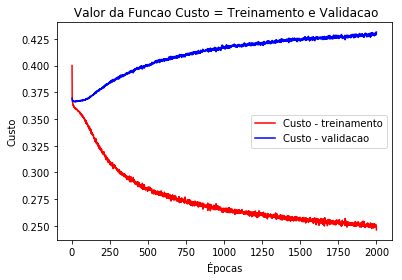

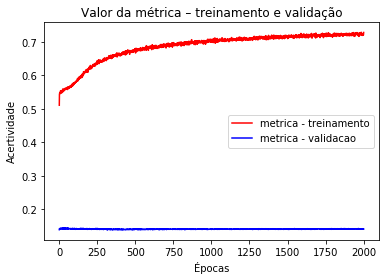

In [19]:
rna0.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna0.plot()

Confusion matrix, without normalization
[[10024   770]
 [ 1572  1443]]


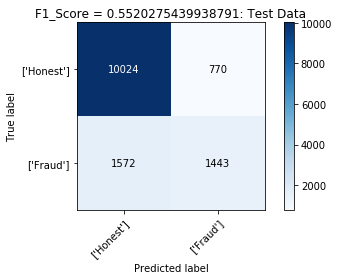

Confusion matrix, without normalization
[[9966  829]
 [1566 1449]]


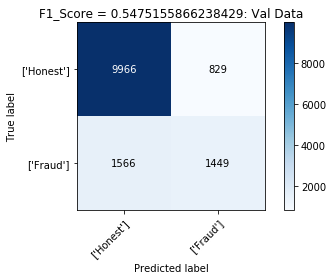

Confusion matrix, without normalization
[[49441   931]
 [ 3661 10407]]


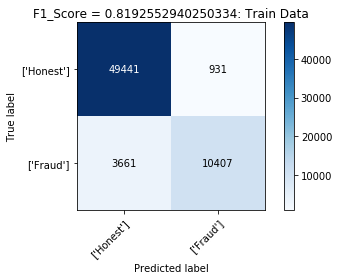

In [20]:
rna0.predict(x_data,y_data)

In [21]:
n_list1 = [100,1]
activation_list1 = ['tanh','sigmoid']
dropout_list1 = [0.3]

In [22]:
rna1 = new_rna()
rna1.build_model(data_shape,n_list1,activation_list1,dropout_list1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3983 - f1: 0.5156 - val_loss: 0.3676 - val_f1: 0.1413
Epoch 2/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3697 - f1: 0.5404 - val_loss: 0.3688 - val_f1: 0.1426
Epoch 3/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3675 - f1: 0.5419 - val_loss: 0.3662 - val_f1: 0.1397
Epoch 4/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3659 - f1: 0.5458 - val_loss: 0.3677 - val_f1: 0.1420
Epoch 5/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3647 - f1: 0.5467 - val_loss: 0.3666 - val_f1: 0.1418
Epoch 6/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.3644 - f1: 0.5474 - val_loss: 0.3665 - val_f1: 0.1419
Epoch 7/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3630 - f1: 0.5495 - val_loss: 0.3665 - val_f1

64440/64440 [==============================] - 2s 36us/step - loss: 0.3547 - f1: 0.5595 - val_loss: 0.3663 - val_f1: 0.1417
Epoch 61/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3538 - f1: 0.5626 - val_loss: 0.3667 - val_f1: 0.1433
Epoch 62/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3534 - f1: 0.5659 - val_loss: 0.3662 - val_f1: 0.1410
Epoch 63/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3527 - f1: 0.5615 - val_loss: 0.3666 - val_f1: 0.1429
Epoch 64/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3533 - f1: 0.5633 - val_loss: 0.3670 - val_f1: 0.1440
Epoch 65/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3529 - f1: 0.5639 - val_loss: 0.3669 - val_f1: 0.1428
Epoch 66/2000
64440/64440 [==============================] - 2s 35us/step - loss: 0.3536 - f1: 0.5630 - val_loss: 0.3665 - val_f1: 0.1421
Epoch 67/2000
64440/64440 [=====================

64440/64440 [==============================] - 2s 36us/step - loss: 0.3347 - f1: 0.5947 - val_loss: 0.3697 - val_f1: 0.1409
Epoch 120/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3350 - f1: 0.5912 - val_loss: 0.3697 - val_f1: 0.1410
Epoch 121/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3348 - f1: 0.5879 - val_loss: 0.3704 - val_f1: 0.1414
Epoch 122/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3344 - f1: 0.5927 - val_loss: 0.3704 - val_f1: 0.1428
Epoch 123/2000
64440/64440 [==============================] - ETA: 0s - loss: 0.3326 - f1: 0.59 - 2s 36us/step - loss: 0.3333 - f1: 0.5940 - val_loss: 0.3707 - val_f1: 0.1432
Epoch 124/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3334 - f1: 0.5975 - val_loss: 0.3710 - val_f1: 0.1422
Epoch 125/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3324 - f1: 0.6015 - val_loss: 0.3705 - val_f1: 0.1413
Epoch 

Epoch 178/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3079 - f1: 0.6372 - val_loss: 0.3783 - val_f1: 0.1429
Epoch 179/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3070 - f1: 0.6416 - val_loss: 0.3785 - val_f1: 0.1422
Epoch 180/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.3064 - f1: 0.6374 - val_loss: 0.3800 - val_f1: 0.1423
Epoch 181/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.3042 - f1: 0.6440 - val_loss: 0.3797 - val_f1: 0.1422
Epoch 182/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.3057 - f1: 0.6410 - val_loss: 0.3803 - val_f1: 0.1414
Epoch 183/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3038 - f1: 0.6446 - val_loss: 0.3800 - val_f1: 0.1418
Epoch 184/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.3031 - f1: 0.6448 - val_loss: 0.3807 - val_f1: 0.1411
Epoch 185/2000
64440/64440 

Epoch 237/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2856 - f1: 0.6713 - val_loss: 0.3899 - val_f1: 0.1419
Epoch 238/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2866 - f1: 0.6739 - val_loss: 0.3896 - val_f1: 0.1418
Epoch 239/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2831 - f1: 0.6748 - val_loss: 0.3913 - val_f1: 0.1424
Epoch 240/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2848 - f1: 0.6770 - val_loss: 0.3893 - val_f1: 0.1426
Epoch 241/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2818 - f1: 0.6791 - val_loss: 0.3916 - val_f1: 0.1401
Epoch 242/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2838 - f1: 0.6781 - val_loss: 0.3908 - val_f1: 0.1417
Epoch 243/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2804 - f1: 0.6785 - val_loss: 0.3918 - val_f1: 0.1424
Epoch 244/2000
64440/64440 

Epoch 296/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2663 - f1: 0.7024 - val_loss: 0.4026 - val_f1: 0.1422
Epoch 297/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2681 - f1: 0.6963 - val_loss: 0.4012 - val_f1: 0.1422
Epoch 298/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.2662 - f1: 0.7012 - val_loss: 0.4026 - val_f1: 0.1425
Epoch 299/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2628 - f1: 0.7070 - val_loss: 0.4036 - val_f1: 0.1410
Epoch 300/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2672 - f1: 0.6973 - val_loss: 0.4018 - val_f1: 0.1416
Epoch 301/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2657 - f1: 0.7021 - val_loss: 0.4017 - val_f1: 0.1416
Epoch 302/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2613 - f1: 0.7078 - val_loss: 0.4040 - val_f1: 0.1417
Epoch 303/2000
64440/64440 

Epoch 355/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2505 - f1: 0.7247 - val_loss: 0.4124 - val_f1: 0.1425
Epoch 356/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2535 - f1: 0.7153 - val_loss: 0.4127 - val_f1: 0.1421
Epoch 357/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2529 - f1: 0.7207 - val_loss: 0.4138 - val_f1: 0.1424
Epoch 358/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2520 - f1: 0.7196 - val_loss: 0.4132 - val_f1: 0.1418
Epoch 359/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2527 - f1: 0.7206 - val_loss: 0.4123 - val_f1: 0.1421
Epoch 360/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2506 - f1: 0.7228 - val_loss: 0.4124 - val_f1: 0.1425
Epoch 361/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2536 - f1: 0.7186 - val_loss: 0.4131 - val_f1: 0.1411
Epoch 362/2000
64440/64440 

Epoch 414/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2436 - f1: 0.7297 - val_loss: 0.4217 - val_f1: 0.1426
Epoch 415/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2437 - f1: 0.7293 - val_loss: 0.4222 - val_f1: 0.1411
Epoch 416/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2424 - f1: 0.7320 - val_loss: 0.4235 - val_f1: 0.1420
Epoch 417/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2413 - f1: 0.7333 - val_loss: 0.4234 - val_f1: 0.1408
Epoch 418/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2423 - f1: 0.7378 - val_loss: 0.4238 - val_f1: 0.1425
Epoch 419/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2405 - f1: 0.7341 - val_loss: 0.4240 - val_f1: 0.1412
Epoch 420/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2421 - f1: 0.7314 - val_loss: 0.4231 - val_f1: 0.1416
Epoch 421/2000
64440/64440 

Epoch 473/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2338 - f1: 0.7451 - val_loss: 0.4321 - val_f1: 0.1418
Epoch 474/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2331 - f1: 0.7431 - val_loss: 0.4321 - val_f1: 0.1414
Epoch 475/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2332 - f1: 0.7459 - val_loss: 0.4316 - val_f1: 0.1436
Epoch 476/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2329 - f1: 0.7474 - val_loss: 0.4322 - val_f1: 0.1423
Epoch 477/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2349 - f1: 0.7423 - val_loss: 0.4323 - val_f1: 0.1429
Epoch 478/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2332 - f1: 0.7422 - val_loss: 0.4322 - val_f1: 0.1427
Epoch 479/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2322 - f1: 0.7446 - val_loss: 0.4322 - val_f1: 0.1428
Epoch 480/2000
64440/64440 

Epoch 532/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2257 - f1: 0.7523 - val_loss: 0.4407 - val_f1: 0.1413
Epoch 533/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2272 - f1: 0.7574 - val_loss: 0.4407 - val_f1: 0.1414
Epoch 534/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2263 - f1: 0.7522 - val_loss: 0.4405 - val_f1: 0.1414
Epoch 535/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2282 - f1: 0.7515 - val_loss: 0.4393 - val_f1: 0.1409
Epoch 536/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2278 - f1: 0.7504 - val_loss: 0.4398 - val_f1: 0.1411
Epoch 537/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2239 - f1: 0.7548 - val_loss: 0.4415 - val_f1: 0.1416
Epoch 538/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2256 - f1: 0.7564 - val_loss: 0.4421 - val_f1: 0.1419
Epoch 539/2000
64440/64440 

Epoch 591/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2212 - f1: 0.7615 - val_loss: 0.4471 - val_f1: 0.1403
Epoch 592/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2204 - f1: 0.7607 - val_loss: 0.4457 - val_f1: 0.1416
Epoch 593/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2229 - f1: 0.7558 - val_loss: 0.4455 - val_f1: 0.1416
Epoch 594/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2197 - f1: 0.7633 - val_loss: 0.4463 - val_f1: 0.1419
Epoch 595/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2190 - f1: 0.7619 - val_loss: 0.4484 - val_f1: 0.1416
Epoch 596/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2209 - f1: 0.7623 - val_loss: 0.4472 - val_f1: 0.1420
Epoch 597/2000
64440/64440 [==============================] - 2s 36us/step - loss: 0.2200 - f1: 0.7630 - val_loss: 0.4462 - val_f1: 0.1411
Epoch 598/2000
64440/64440 

Epoch 650/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2163 - f1: 0.7711 - val_loss: 0.4524 - val_f1: 0.1405
Epoch 651/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2159 - f1: 0.7677 - val_loss: 0.4530 - val_f1: 0.1408
Epoch 652/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2144 - f1: 0.7647 - val_loss: 0.4531 - val_f1: 0.1408
Epoch 653/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2137 - f1: 0.7686 - val_loss: 0.4525 - val_f1: 0.1428
Epoch 654/2000
64440/64440 [==============================] - 2s 39us/step - loss: 0.2138 - f1: 0.7703 - val_loss: 0.4529 - val_f1: 0.1409
Epoch 655/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2150 - f1: 0.7679 - val_loss: 0.4531 - val_f1: 0.1419
Epoch 656/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2159 - f1: 0.7664 - val_loss: 0.4547 - val_f1: 0.1414
Epoch 657/2000
64440/64440 

64440/64440 [==============================] - 2s 37us/step - loss: 0.2096 - f1: 0.7759 - val_loss: 0.4569 - val_f1: 0.1413
Epoch 709/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2082 - f1: 0.7758 - val_loss: 0.4581 - val_f1: 0.1418
Epoch 710/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2100 - f1: 0.7731 - val_loss: 0.4591 - val_f1: 0.1399
Epoch 711/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2105 - f1: 0.7759 - val_loss: 0.4590 - val_f1: 0.1406
Epoch 712/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2112 - f1: 0.7744 - val_loss: 0.4584 - val_f1: 0.1407
Epoch 713/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2075 - f1: 0.7741 - val_loss: 0.4597 - val_f1: 0.1417
Epoch 714/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2083 - f1: 0.7731 - val_loss: 0.4613 - val_f1: 0.1412
Epoch 715/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 37us/step - loss: 0.2059 - f1: 0.7749 - val_loss: 0.4645 - val_f1: 0.1407
Epoch 768/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2091 - f1: 0.7739 - val_loss: 0.4629 - val_f1: 0.1412
Epoch 769/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2046 - f1: 0.7798 - val_loss: 0.4638 - val_f1: 0.1409
Epoch 770/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2063 - f1: 0.7801 - val_loss: 0.4647 - val_f1: 0.1412
Epoch 771/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2070 - f1: 0.7775 - val_loss: 0.4630 - val_f1: 0.1417
Epoch 772/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2085 - f1: 0.7781 - val_loss: 0.4635 - val_f1: 0.1404
Epoch 773/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.2089 - f1: 0.7726 - val_loss: 0.4632 - val_f1: 0.1403
Epoch 774/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 37us/step - loss: 0.2039 - f1: 0.7779 - val_loss: 0.4707 - val_f1: 0.1417
Epoch 827/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2052 - f1: 0.7777 - val_loss: 0.4684 - val_f1: 0.1414
Epoch 828/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2032 - f1: 0.7805 - val_loss: 0.4670 - val_f1: 0.1421
Epoch 829/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2020 - f1: 0.7806 - val_loss: 0.4686 - val_f1: 0.1413
Epoch 830/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2047 - f1: 0.7818 - val_loss: 0.4672 - val_f1: 0.1418
Epoch 831/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2025 - f1: 0.7823 - val_loss: 0.4693 - val_f1: 0.1415
Epoch 832/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2055 - f1: 0.7778 - val_loss: 0.4683 - val_f1: 0.1417
Epoch 833/2000
64440/64440 [==============

64440/64440 [==============================] - 2s 38us/step - loss: 0.2008 - f1: 0.7837 - val_loss: 0.4716 - val_f1: 0.1413
Epoch 886/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1979 - f1: 0.7889 - val_loss: 0.4715 - val_f1: 0.1421
Epoch 887/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2013 - f1: 0.7857 - val_loss: 0.4720 - val_f1: 0.1412
Epoch 888/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1985 - f1: 0.7910 - val_loss: 0.4737 - val_f1: 0.1419
Epoch 889/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1990 - f1: 0.7926 - val_loss: 0.4744 - val_f1: 0.1419
Epoch 890/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1974 - f1: 0.7881 - val_loss: 0.4743 - val_f1: 0.1406
Epoch 891/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2014 - f1: 0.7850 - val_loss: 0.4710 - val_f1: 0.1416
Epoch 892/2000
64440/64440 [==============

Epoch 944/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1981 - f1: 0.7881 - val_loss: 0.4745 - val_f1: 0.1417
Epoch 945/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1997 - f1: 0.7872 - val_loss: 0.4748 - val_f1: 0.1420
Epoch 946/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1947 - f1: 0.7926 - val_loss: 0.4762 - val_f1: 0.1410
Epoch 947/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1961 - f1: 0.7948 - val_loss: 0.4769 - val_f1: 0.1410
Epoch 948/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1975 - f1: 0.7935 - val_loss: 0.4758 - val_f1: 0.1412
Epoch 949/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1991 - f1: 0.7897 - val_loss: 0.4757 - val_f1: 0.1418
Epoch 950/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1986 - f1: 0.7881 - val_loss: 0.4748 - val_f1: 0.1412
Epoch 951/2000
64440/64440 

Epoch 1003/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1950 - f1: 0.7915 - val_loss: 0.4775 - val_f1: 0.1417
Epoch 1004/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1919 - f1: 0.7959 - val_loss: 0.4809 - val_f1: 0.1412
Epoch 1005/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1931 - f1: 0.7917 - val_loss: 0.4801 - val_f1: 0.1419
Epoch 1006/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1938 - f1: 0.7927 - val_loss: 0.4804 - val_f1: 0.1429
Epoch 1007/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1968 - f1: 0.7915 - val_loss: 0.4792 - val_f1: 0.1420
Epoch 1008/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.1949 - f1: 0.7894 - val_loss: 0.4790 - val_f1: 0.1422
Epoch 1009/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1961 - f1: 0.7921 - val_loss: 0.4775 - val_f1: 0.1425
Epoch 1010/2000
6444

64440/64440 [==============================] - 2s 37us/step - loss: 0.1925 - f1: 0.7946 - val_loss: 0.4824 - val_f1: 0.1414
Epoch 1062/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1920 - f1: 0.7964 - val_loss: 0.4836 - val_f1: 0.1406
Epoch 1063/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1961 - f1: 0.7923 - val_loss: 0.4801 - val_f1: 0.1415
Epoch 1064/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1924 - f1: 0.7950 - val_loss: 0.4811 - val_f1: 0.1411
Epoch 1065/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1929 - f1: 0.7933 - val_loss: 0.4809 - val_f1: 0.1404
Epoch 1066/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1913 - f1: 0.7972 - val_loss: 0.4815 - val_f1: 0.1416
Epoch 1067/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.1925 - f1: 0.7946 - val_loss: 0.4830 - val_f1: 0.1412
Epoch 1068/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 40us/step - loss: 0.1914 - f1: 0.7969 - val_loss: 0.4835 - val_f1: 0.1409
Epoch 1120/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1908 - f1: 0.7916 - val_loss: 0.4831 - val_f1: 0.1404
Epoch 1121/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1905 - f1: 0.7953 - val_loss: 0.4854 - val_f1: 0.1417
Epoch 1122/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1911 - f1: 0.7974 - val_loss: 0.4843 - val_f1: 0.1410
Epoch 1123/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1895 - f1: 0.7973 - val_loss: 0.4831 - val_f1: 0.1421
Epoch 1124/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1924 - f1: 0.7946 - val_loss: 0.4842 - val_f1: 0.1411
Epoch 1125/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1901 - f1: 0.7973 - val_loss: 0.4840 - val_f1: 0.1415
Epoch 1126/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1879 - f1: 0.7997 - val_loss: 0.4879 - val_f1: 0.1411
Epoch 1178/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1883 - f1: 0.7994 - val_loss: 0.4888 - val_f1: 0.1408
Epoch 1179/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1864 - f1: 0.8004 - val_loss: 0.4902 - val_f1: 0.1407
Epoch 1180/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1908 - f1: 0.7954 - val_loss: 0.4881 - val_f1: 0.1418
Epoch 1181/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1888 - f1: 0.7996 - val_loss: 0.4872 - val_f1: 0.1428
Epoch 1182/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1871 - f1: 0.8017 - val_loss: 0.4892 - val_f1: 0.1413
Epoch 1183/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1896 - f1: 0.7992 - val_loss: 0.4885 - val_f1: 0.1411
Epoch 1184/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1839 - f1: 0.8030 - val_loss: 0.4915 - val_f1: 0.1418
Epoch 1236/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1894 - f1: 0.8005 - val_loss: 0.4896 - val_f1: 0.1415
Epoch 1237/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.1872 - f1: 0.8045 - val_loss: 0.4890 - val_f1: 0.1409
Epoch 1238/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1896 - f1: 0.7983 - val_loss: 0.4887 - val_f1: 0.1415
Epoch 1239/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1896 - f1: 0.8002 - val_loss: 0.4892 - val_f1: 0.1406
Epoch 1240/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1859 - f1: 0.8019 - val_loss: 0.4895 - val_f1: 0.1409
Epoch 1241/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1877 - f1: 0.7999 - val_loss: 0.4893 - val_f1: 0.1411
Epoch 1242/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1848 - f1: 0.8083 - val_loss: 0.4931 - val_f1: 0.1398
Epoch 1294/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1863 - f1: 0.8034 - val_loss: 0.4921 - val_f1: 0.1412
Epoch 1295/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1854 - f1: 0.8030 - val_loss: 0.4919 - val_f1: 0.1409
Epoch 1296/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1874 - f1: 0.8047 - val_loss: 0.4902 - val_f1: 0.1410
Epoch 1297/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1854 - f1: 0.8035 - val_loss: 0.4895 - val_f1: 0.1417
Epoch 1298/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1864 - f1: 0.8007 - val_loss: 0.4915 - val_f1: 0.1421
Epoch 1299/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1861 - f1: 0.7990 - val_loss: 0.4926 - val_f1: 0.1413
Epoch 1300/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1867 - f1: 0.8024 - val_loss: 0.4927 - val_f1: 0.1410
Epoch 1352/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1827 - f1: 0.8060 - val_loss: 0.4943 - val_f1: 0.1412
Epoch 1353/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1838 - f1: 0.8073 - val_loss: 0.4945 - val_f1: 0.1411
Epoch 1354/2000
64440/64440 [==============================] - 2s 39us/step - loss: 0.1812 - f1: 0.8061 - val_loss: 0.4964 - val_f1: 0.1407
Epoch 1355/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1827 - f1: 0.8033 - val_loss: 0.4951 - val_f1: 0.1415
Epoch 1356/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.1857 - f1: 0.8029 - val_loss: 0.4937 - val_f1: 0.1410
Epoch 1357/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1836 - f1: 0.8060 - val_loss: 0.4935 - val_f1: 0.1419
Epoch 1358/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1807 - f1: 0.8095 - val_loss: 0.4981 - val_f1: 0.1421
Epoch 1410/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1827 - f1: 0.8077 - val_loss: 0.4986 - val_f1: 0.1421
Epoch 1411/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1847 - f1: 0.8052 - val_loss: 0.4952 - val_f1: 0.1407
Epoch 1412/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1835 - f1: 0.8054 - val_loss: 0.4972 - val_f1: 0.1416
Epoch 1413/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1823 - f1: 0.8070 - val_loss: 0.4957 - val_f1: 0.1416
Epoch 1414/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.1824 - f1: 0.8065 - val_loss: 0.4957 - val_f1: 0.1424
Epoch 1415/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1844 - f1: 0.8071 - val_loss: 0.4942 - val_f1: 0.1419
Epoch 1416/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1816 - f1: 0.8072 - val_loss: 0.4986 - val_f1: 0.1419
Epoch 1468/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1813 - f1: 0.8087 - val_loss: 0.4971 - val_f1: 0.1423
Epoch 1469/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1806 - f1: 0.8098 - val_loss: 0.4991 - val_f1: 0.1418
Epoch 1470/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1809 - f1: 0.8099 - val_loss: 0.4994 - val_f1: 0.1415
Epoch 1471/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1807 - f1: 0.8073 - val_loss: 0.4995 - val_f1: 0.1422
Epoch 1472/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.1809 - f1: 0.8070 - val_loss: 0.4975 - val_f1: 0.1420
Epoch 1473/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1819 - f1: 0.8070 - val_loss: 0.4980 - val_f1: 0.1417
Epoch 1474/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 39us/step - loss: 0.1796 - f1: 0.8122 - val_loss: 0.4994 - val_f1: 0.1416
Epoch 1526/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.1806 - f1: 0.8099 - val_loss: 0.5008 - val_f1: 0.1411
Epoch 1527/2000
64440/64440 [==============================] - 2s 39us/step - loss: 0.1798 - f1: 0.8088 - val_loss: 0.4989 - val_f1: 0.1416
Epoch 1528/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1791 - f1: 0.8125 - val_loss: 0.5016 - val_f1: 0.1411
Epoch 1529/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1801 - f1: 0.8094 - val_loss: 0.5016 - val_f1: 0.1415
Epoch 1530/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1790 - f1: 0.8110 - val_loss: 0.5004 - val_f1: 0.1414
Epoch 1531/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1769 - f1: 0.8120 - val_loss: 0.5021 - val_f1: 0.1408
Epoch 1532/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 40us/step - loss: 0.1790 - f1: 0.8122 - val_loss: 0.5015 - val_f1: 0.1402
Epoch 1584/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1783 - f1: 0.8122 - val_loss: 0.5026 - val_f1: 0.1420
Epoch 1585/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1773 - f1: 0.8151 - val_loss: 0.5041 - val_f1: 0.1409
Epoch 1586/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1774 - f1: 0.8154 - val_loss: 0.5023 - val_f1: 0.1422
Epoch 1587/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1796 - f1: 0.8092 - val_loss: 0.5024 - val_f1: 0.1418
Epoch 1588/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1778 - f1: 0.8088 - val_loss: 0.5024 - val_f1: 0.1410
Epoch 1589/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1807 - f1: 0.8100 - val_loss: 0.5017 - val_f1: 0.1416
Epoch 1590/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1756 - f1: 0.8127 - val_loss: 0.5037 - val_f1: 0.1412
Epoch 1642/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1741 - f1: 0.8181 - val_loss: 0.5062 - val_f1: 0.1414
Epoch 1643/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1746 - f1: 0.8138 - val_loss: 0.5065 - val_f1: 0.1411
Epoch 1644/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1757 - f1: 0.8177 - val_loss: 0.5057 - val_f1: 0.1407
Epoch 1645/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1759 - f1: 0.8160 - val_loss: 0.5076 - val_f1: 0.1399
Epoch 1646/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1793 - f1: 0.8088 - val_loss: 0.5045 - val_f1: 0.1412
Epoch 1647/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1782 - f1: 0.8139 - val_loss: 0.5038 - val_f1: 0.1404
Epoch 1648/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 39us/step - loss: 0.1780 - f1: 0.8157 - val_loss: 0.5039 - val_f1: 0.1418
Epoch 1700/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1780 - f1: 0.8143 - val_loss: 0.5051 - val_f1: 0.1411
Epoch 1701/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.1751 - f1: 0.8164 - val_loss: 0.5050 - val_f1: 0.1413
Epoch 1702/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1773 - f1: 0.8113 - val_loss: 0.5036 - val_f1: 0.1415
Epoch 1703/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1751 - f1: 0.8151 - val_loss: 0.5053 - val_f1: 0.1412
Epoch 1704/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1767 - f1: 0.8124 - val_loss: 0.5045 - val_f1: 0.1416
Epoch 1705/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1773 - f1: 0.8122 - val_loss: 0.5043 - val_f1: 0.1419
Epoch 1706/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1770 - f1: 0.8170 - val_loss: 0.5059 - val_f1: 0.1414
Epoch 1758/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1735 - f1: 0.8208 - val_loss: 0.5069 - val_f1: 0.1404
Epoch 1759/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.1764 - f1: 0.8136 - val_loss: 0.5049 - val_f1: 0.1406
Epoch 1760/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1747 - f1: 0.8142 - val_loss: 0.5064 - val_f1: 0.1416
Epoch 1761/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1756 - f1: 0.8133 - val_loss: 0.5077 - val_f1: 0.1403
Epoch 1762/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1756 - f1: 0.8154 - val_loss: 0.5070 - val_f1: 0.1415
Epoch 1763/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1742 - f1: 0.8117 - val_loss: 0.5077 - val_f1: 0.1410
Epoch 1764/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1744 - f1: 0.8157 - val_loss: 0.5072 - val_f1: 0.1415
Epoch 1816/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1750 - f1: 0.8178 - val_loss: 0.5088 - val_f1: 0.1409
Epoch 1817/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1760 - f1: 0.8120 - val_loss: 0.5083 - val_f1: 0.1419
Epoch 1818/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.1716 - f1: 0.8219 - val_loss: 0.5102 - val_f1: 0.1410
Epoch 1819/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1724 - f1: 0.8194 - val_loss: 0.5087 - val_f1: 0.1418
Epoch 1820/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1712 - f1: 0.8194 - val_loss: 0.5099 - val_f1: 0.1402
Epoch 1821/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1728 - f1: 0.8198 - val_loss: 0.5121 - val_f1: 0.1414
Epoch 1822/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1760 - f1: 0.8141 - val_loss: 0.5105 - val_f1: 0.1414
Epoch 1874/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1720 - f1: 0.8197 - val_loss: 0.5111 - val_f1: 0.1412
Epoch 1875/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1754 - f1: 0.8129 - val_loss: 0.5100 - val_f1: 0.1421
Epoch 1876/2000
64440/64440 [==============================] - 2s 39us/step - loss: 0.1734 - f1: 0.8148 - val_loss: 0.5117 - val_f1: 0.1416
Epoch 1877/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.1760 - f1: 0.8157 - val_loss: 0.5088 - val_f1: 0.1408
Epoch 1878/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1699 - f1: 0.8223 - val_loss: 0.5125 - val_f1: 0.1406
Epoch 1879/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1756 - f1: 0.8152 - val_loss: 0.5121 - val_f1: 0.1401
Epoch 1880/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 38us/step - loss: 0.1723 - f1: 0.8171 - val_loss: 0.5102 - val_f1: 0.1417
Epoch 1932/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1726 - f1: 0.8184 - val_loss: 0.5112 - val_f1: 0.1420
Epoch 1933/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1715 - f1: 0.8210 - val_loss: 0.5113 - val_f1: 0.1413
Epoch 1934/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1731 - f1: 0.8190 - val_loss: 0.5114 - val_f1: 0.1404
Epoch 1935/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.1711 - f1: 0.8177 - val_loss: 0.5134 - val_f1: 0.1406
Epoch 1936/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.1743 - f1: 0.8153 - val_loss: 0.5116 - val_f1: 0.1412
Epoch 1937/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1700 - f1: 0.8239 - val_loss: 0.5135 - val_f1: 0.1416
Epoch 1938/2000
64440/64440 [=======

64440/64440 [==============================] - 2s 37us/step - loss: 0.1719 - f1: 0.8168 - val_loss: 0.5145 - val_f1: 0.1417
Epoch 1990/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1699 - f1: 0.8180 - val_loss: 0.5149 - val_f1: 0.1416
Epoch 1991/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1720 - f1: 0.8192 - val_loss: 0.5145 - val_f1: 0.1404
Epoch 1992/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1734 - f1: 0.8176 - val_loss: 0.5137 - val_f1: 0.1413
Epoch 1993/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1688 - f1: 0.8223 - val_loss: 0.5143 - val_f1: 0.1416
Epoch 1994/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.1741 - f1: 0.8163 - val_loss: 0.5130 - val_f1: 0.1419
Epoch 1995/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.1708 - f1: 0.8215 - val_loss: 0.5142 - val_f1: 0.1411
Epoch 1996/2000
64440/64440 [=======

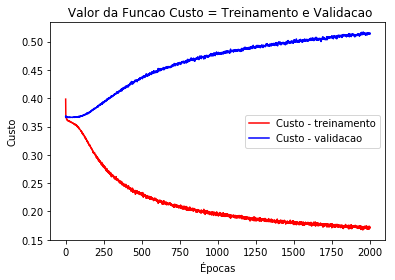

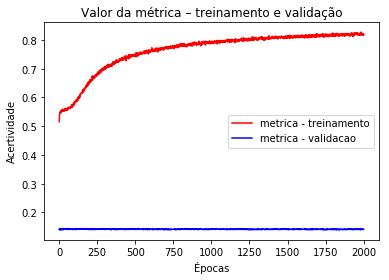

In [23]:
rna1.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna1.plot()

Confusion matrix, without normalization
[[10028   766]
 [ 1558  1457]]


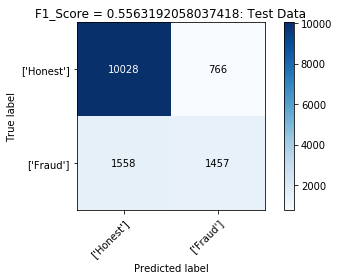

Confusion matrix, without normalization
[[9932  863]
 [1565 1450]]


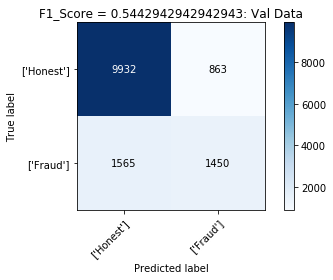

Confusion matrix, without normalization
[[50225   147]
 [ 1108 12960]]


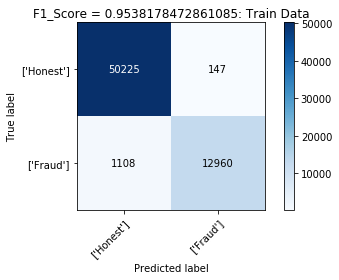

In [24]:
rna1.predict(x_data,y_data)

In [25]:
n_list2 = [50,50,1]
activation_list2 = ['tanh','tanh','sigmoid']
dropout_list2 = [0.3,0.3]

In [26]:
rna2 = new_rna()
rna2.build_model(data_shape,n_list2,activation_list2,dropout_list2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.4074 - f1: 0.4803 - val_loss: 0.3695 - val_f1: 0.1426
Epoch 2/2000
64440/64440 [==============================] - 2s 39us/step - loss: 0.3761 - f1: 0.5358 - val_loss: 0.3672 - val_f1: 0.1426
Epoch 3/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3720 - f1: 0.5389 - val_loss: 0.3676 - val_f1: 0.1450
Epoch 4/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3701 - f1: 0.5455 - val_loss: 0.3668 - val_f1: 0.1449
Epoch 5/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3683 - f1: 0.5473 - val_loss: 0.3674 - val_f1: 0.1447
Epoch 6/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.3673 - f1: 0.5475 - val_loss: 0.3677 - val_f1: 0.1447
Epoch 7/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3662 - f1: 0.5520 - val_loss: 0.3680 - val_f1

64440/64440 [==============================] - 3s 40us/step - loss: 0.3540 - f1: 0.5665 - val_loss: 0.3704 - val_f1: 0.1463
Epoch 61/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3537 - f1: 0.5715 - val_loss: 0.3712 - val_f1: 0.1454
Epoch 62/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.3549 - f1: 0.5627 - val_loss: 0.3689 - val_f1: 0.1448
Epoch 63/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.3539 - f1: 0.5666 - val_loss: 0.3691 - val_f1: 0.1446
Epoch 64/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.3542 - f1: 0.5649 - val_loss: 0.3696 - val_f1: 0.1452
Epoch 65/2000
64440/64440 [==============================] - 2s 38us/step - loss: 0.3527 - f1: 0.5673 - val_loss: 0.3694 - val_f1: 0.1441
Epoch 66/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3533 - f1: 0.5653 - val_loss: 0.3694 - val_f1: 0.1453
Epoch 67/2000
64440/64440 [=====================

64440/64440 [==============================] - 3s 40us/step - loss: 0.3415 - f1: 0.5844 - val_loss: 0.3731 - val_f1: 0.1450
Epoch 120/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3419 - f1: 0.5795 - val_loss: 0.3749 - val_f1: 0.1454
Epoch 121/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3423 - f1: 0.5832 - val_loss: 0.3739 - val_f1: 0.1456
Epoch 122/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3420 - f1: 0.5802 - val_loss: 0.3726 - val_f1: 0.1455
Epoch 123/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3418 - f1: 0.5870 - val_loss: 0.3727 - val_f1: 0.1447
Epoch 124/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3416 - f1: 0.5848 - val_loss: 0.3748 - val_f1: 0.1449
Epoch 125/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.3404 - f1: 0.5822 - val_loss: 0.3740 - val_f1: 0.1440
Epoch 126/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 42us/step - loss: 0.3309 - f1: 0.6074 - val_loss: 0.3786 - val_f1: 0.1442
Epoch 179/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3287 - f1: 0.6107 - val_loss: 0.3790 - val_f1: 0.1442
Epoch 180/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3281 - f1: 0.6126 - val_loss: 0.3812 - val_f1: 0.1455
Epoch 181/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.3302 - f1: 0.6117 - val_loss: 0.3786 - val_f1: 0.1437
Epoch 182/2000
64440/64440 [==============================] - 3s 39us/step - loss: 0.3296 - f1: 0.6059 - val_loss: 0.3790 - val_f1: 0.1439
Epoch 183/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.3275 - f1: 0.6098 - val_loss: 0.3786 - val_f1: 0.1445
Epoch 184/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.3285 - f1: 0.6110 - val_loss: 0.3798 - val_f1: 0.1437
Epoch 185/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 44us/step - loss: 0.3183 - f1: 0.6292 - val_loss: 0.3859 - val_f1: 0.1444
Epoch 238/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3197 - f1: 0.6186 - val_loss: 0.3845 - val_f1: 0.1445
Epoch 239/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3173 - f1: 0.6341 - val_loss: 0.3867 - val_f1: 0.1443
Epoch 240/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.3192 - f1: 0.6238 - val_loss: 0.3887 - val_f1: 0.1431
Epoch 241/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3172 - f1: 0.6288 - val_loss: 0.3891 - val_f1: 0.1451
Epoch 242/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3183 - f1: 0.6258 - val_loss: 0.3884 - val_f1: 0.1450
Epoch 243/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.3197 - f1: 0.6264 - val_loss: 0.3839 - val_f1: 0.1438
Epoch 244/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 40us/step - loss: 0.3102 - f1: 0.6410 - val_loss: 0.3920 - val_f1: 0.1457
Epoch 297/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.3092 - f1: 0.6457 - val_loss: 0.3887 - val_f1: 0.1460
Epoch 298/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3083 - f1: 0.6438 - val_loss: 0.3893 - val_f1: 0.1454
Epoch 299/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3090 - f1: 0.6428 - val_loss: 0.3903 - val_f1: 0.1461
Epoch 300/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.3109 - f1: 0.6368 - val_loss: 0.3886 - val_f1: 0.1452
Epoch 301/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3091 - f1: 0.6419 - val_loss: 0.3929 - val_f1: 0.1460
Epoch 302/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.3099 - f1: 0.6352 - val_loss: 0.3916 - val_f1: 0.1455
Epoch 303/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 41us/step - loss: 0.3028 - f1: 0.6560 - val_loss: 0.3935 - val_f1: 0.1460
Epoch 356/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.3018 - f1: 0.6544 - val_loss: 0.3922 - val_f1: 0.1460
Epoch 357/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.3032 - f1: 0.6532 - val_loss: 0.3952 - val_f1: 0.1458
Epoch 358/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3015 - f1: 0.6527 - val_loss: 0.3945 - val_f1: 0.1454
Epoch 359/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3032 - f1: 0.6522 - val_loss: 0.3956 - val_f1: 0.1463
Epoch 360/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.3020 - f1: 0.6531 - val_loss: 0.3966 - val_f1: 0.1459
Epoch 361/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.3042 - f1: 0.6496 - val_loss: 0.3964 - val_f1: 0.1459
Epoch 362/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 41us/step - loss: 0.2977 - f1: 0.6557 - val_loss: 0.3972 - val_f1: 0.1462
Epoch 415/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2971 - f1: 0.6676 - val_loss: 0.3961 - val_f1: 0.1455
Epoch 416/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2979 - f1: 0.6624 - val_loss: 0.3982 - val_f1: 0.1456
Epoch 417/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2977 - f1: 0.6579 - val_loss: 0.3977 - val_f1: 0.1465
Epoch 418/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2970 - f1: 0.6663 - val_loss: 0.3973 - val_f1: 0.1463
Epoch 419/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2972 - f1: 0.6621 - val_loss: 0.4025 - val_f1: 0.1466
Epoch 420/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2982 - f1: 0.6621 - val_loss: 0.3982 - val_f1: 0.1454
Epoch 421/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 44us/step - loss: 0.2927 - f1: 0.6686 - val_loss: 0.4013 - val_f1: 0.1468
Epoch 474/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2931 - f1: 0.6717 - val_loss: 0.4038 - val_f1: 0.1459
Epoch 475/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2929 - f1: 0.6703 - val_loss: 0.4009 - val_f1: 0.1458
Epoch 476/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2925 - f1: 0.6710 - val_loss: 0.4026 - val_f1: 0.1462
Epoch 477/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2908 - f1: 0.6685 - val_loss: 0.4067 - val_f1: 0.1459
Epoch 478/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2927 - f1: 0.6723 - val_loss: 0.4008 - val_f1: 0.1459
Epoch 479/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2905 - f1: 0.6719 - val_loss: 0.4085 - val_f1: 0.1466
Epoch 480/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 44us/step - loss: 0.2914 - f1: 0.6688 - val_loss: 0.4069 - val_f1: 0.1458
Epoch 533/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2898 - f1: 0.6751 - val_loss: 0.4023 - val_f1: 0.1450
Epoch 534/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2894 - f1: 0.6738 - val_loss: 0.3997 - val_f1: 0.1460
Epoch 535/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2893 - f1: 0.6728 - val_loss: 0.4034 - val_f1: 0.1457
Epoch 536/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2896 - f1: 0.6714 - val_loss: 0.4057 - val_f1: 0.1468
Epoch 537/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2861 - f1: 0.6799 - val_loss: 0.4028 - val_f1: 0.1467
Epoch 538/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2893 - f1: 0.6773 - val_loss: 0.4060 - val_f1: 0.1463
Epoch 539/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 44us/step - loss: 0.2845 - f1: 0.6817 - val_loss: 0.4059 - val_f1: 0.1453
Epoch 592/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2845 - f1: 0.6812 - val_loss: 0.4090 - val_f1: 0.1456
Epoch 593/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2849 - f1: 0.6817 - val_loss: 0.4082 - val_f1: 0.1458
Epoch 594/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2843 - f1: 0.6818 - val_loss: 0.4104 - val_f1: 0.1453
Epoch 595/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2855 - f1: 0.6831 - val_loss: 0.4055 - val_f1: 0.1460
Epoch 596/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2860 - f1: 0.6817 - val_loss: 0.4043 - val_f1: 0.1461
Epoch 597/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2855 - f1: 0.6820 - val_loss: 0.4047 - val_f1: 0.1454
Epoch 598/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 44us/step - loss: 0.2805 - f1: 0.6873 - val_loss: 0.4084 - val_f1: 0.1461
Epoch 651/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2827 - f1: 0.6831 - val_loss: 0.4055 - val_f1: 0.1458
Epoch 652/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2851 - f1: 0.6837 - val_loss: 0.4071 - val_f1: 0.1451
Epoch 653/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2826 - f1: 0.6843 - val_loss: 0.4146 - val_f1: 0.1463
Epoch 654/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2820 - f1: 0.6847 - val_loss: 0.4074 - val_f1: 0.1462
Epoch 655/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2822 - f1: 0.6857 - val_loss: 0.4083 - val_f1: 0.1459
Epoch 656/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2823 - f1: 0.6836 - val_loss: 0.4063 - val_f1: 0.1457
Epoch 657/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 45us/step - loss: 0.2819 - f1: 0.6902 - val_loss: 0.4132 - val_f1: 0.1459
Epoch 710/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2803 - f1: 0.6898 - val_loss: 0.4124 - val_f1: 0.1459
Epoch 711/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2809 - f1: 0.6889 - val_loss: 0.4113 - val_f1: 0.1454
Epoch 712/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2799 - f1: 0.6915 - val_loss: 0.4076 - val_f1: 0.1450
Epoch 713/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2794 - f1: 0.6876 - val_loss: 0.4128 - val_f1: 0.1468
Epoch 714/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2807 - f1: 0.6872 - val_loss: 0.4069 - val_f1: 0.1461
Epoch 715/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.2805 - f1: 0.6881 - val_loss: 0.4125 - val_f1: 0.1458
Epoch 716/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 44us/step - loss: 0.2771 - f1: 0.6944 - val_loss: 0.4104 - val_f1: 0.1459
Epoch 769/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2766 - f1: 0.6928 - val_loss: 0.4114 - val_f1: 0.1459
Epoch 770/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2783 - f1: 0.6928 - val_loss: 0.4098 - val_f1: 0.1460
Epoch 771/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2803 - f1: 0.6923 - val_loss: 0.4078 - val_f1: 0.1457
Epoch 772/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2754 - f1: 0.6983 - val_loss: 0.4147 - val_f1: 0.1464
Epoch 773/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2753 - f1: 0.6957 - val_loss: 0.4112 - val_f1: 0.1460
Epoch 774/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2776 - f1: 0.6963 - val_loss: 0.4127 - val_f1: 0.1460
Epoch 775/2000
64440/64440 [==============

Epoch 827/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2762 - f1: 0.6951 - val_loss: 0.4125 - val_f1: 0.1461
Epoch 828/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.2750 - f1: 0.6952 - val_loss: 0.4145 - val_f1: 0.1459
Epoch 829/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2777 - f1: 0.6964 - val_loss: 0.4131 - val_f1: 0.1456
Epoch 830/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2757 - f1: 0.6938 - val_loss: 0.4119 - val_f1: 0.1462
Epoch 831/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2762 - f1: 0.6948 - val_loss: 0.4128 - val_f1: 0.1459
Epoch 832/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2782 - f1: 0.6905 - val_loss: 0.4148 - val_f1: 0.1468
Epoch 833/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2759 - f1: 0.6974 - val_loss: 0.4172 - val_f1: 0.1459
Epoch 834/2000
64440/64440 

Epoch 886/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2742 - f1: 0.6963 - val_loss: 0.4127 - val_f1: 0.1455
Epoch 887/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2728 - f1: 0.6982 - val_loss: 0.4131 - val_f1: 0.1453
Epoch 888/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2742 - f1: 0.6982 - val_loss: 0.4163 - val_f1: 0.1458
Epoch 889/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2740 - f1: 0.6945 - val_loss: 0.4141 - val_f1: 0.1456
Epoch 890/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2755 - f1: 0.6943 - val_loss: 0.4149 - val_f1: 0.1461
Epoch 891/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2760 - f1: 0.6979 - val_loss: 0.4174 - val_f1: 0.1460
Epoch 892/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2752 - f1: 0.6926 - val_loss: 0.4133 - val_f1: 0.1455
Epoch 893/2000
64440/64440 

Epoch 945/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2742 - f1: 0.6935 - val_loss: 0.4151 - val_f1: 0.1452
Epoch 946/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2711 - f1: 0.6980 - val_loss: 0.4196 - val_f1: 0.1450
Epoch 947/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2730 - f1: 0.6965 - val_loss: 0.4146 - val_f1: 0.1455
Epoch 948/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2726 - f1: 0.7039 - val_loss: 0.4184 - val_f1: 0.1456
Epoch 949/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2731 - f1: 0.7004 - val_loss: 0.4137 - val_f1: 0.1453
Epoch 950/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2727 - f1: 0.6991 - val_loss: 0.4204 - val_f1: 0.1458
Epoch 951/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2725 - f1: 0.6999 - val_loss: 0.4191 - val_f1: 0.1460
Epoch 952/2000
64440/64440 

Epoch 1004/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2712 - f1: 0.7001 - val_loss: 0.4178 - val_f1: 0.1458
Epoch 1005/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2700 - f1: 0.7043 - val_loss: 0.4232 - val_f1: 0.1461
Epoch 1006/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2692 - f1: 0.7022 - val_loss: 0.4170 - val_f1: 0.1465
Epoch 1007/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2730 - f1: 0.6972 - val_loss: 0.4158 - val_f1: 0.1455
Epoch 1008/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2694 - f1: 0.7030 - val_loss: 0.4236 - val_f1: 0.1458
Epoch 1009/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2722 - f1: 0.6976 - val_loss: 0.4201 - val_f1: 0.1453
Epoch 1010/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2708 - f1: 0.7032 - val_loss: 0.4218 - val_f1: 0.1452
Epoch 1011/2000
6444

64440/64440 [==============================] - 3s 41us/step - loss: 0.2682 - f1: 0.7073 - val_loss: 0.4192 - val_f1: 0.1460
Epoch 1063/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2719 - f1: 0.6997 - val_loss: 0.4198 - val_f1: 0.1453
Epoch 1064/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2698 - f1: 0.7043 - val_loss: 0.4208 - val_f1: 0.1454
Epoch 1065/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2720 - f1: 0.7026 - val_loss: 0.4139 - val_f1: 0.1452
Epoch 1066/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2682 - f1: 0.7039 - val_loss: 0.4194 - val_f1: 0.1457
Epoch 1067/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2702 - f1: 0.7025 - val_loss: 0.4200 - val_f1: 0.1455
Epoch 1068/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2715 - f1: 0.7028 - val_loss: 0.4220 - val_f1: 0.1457
Epoch 1069/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2697 - f1: 0.6993 - val_loss: 0.4173 - val_f1: 0.1454
Epoch 1121/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2683 - f1: 0.7094 - val_loss: 0.4154 - val_f1: 0.1461
Epoch 1122/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2654 - f1: 0.7136 - val_loss: 0.4329 - val_f1: 0.1460
Epoch 1123/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2682 - f1: 0.7053 - val_loss: 0.4173 - val_f1: 0.1448
Epoch 1124/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2679 - f1: 0.7048 - val_loss: 0.4239 - val_f1: 0.1461
Epoch 1125/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2687 - f1: 0.7012 - val_loss: 0.4195 - val_f1: 0.1459
Epoch 1126/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2689 - f1: 0.7061 - val_loss: 0.4199 - val_f1: 0.1456
Epoch 1127/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2661 - f1: 0.7073 - val_loss: 0.4252 - val_f1: 0.1455
Epoch 1179/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2669 - f1: 0.7103 - val_loss: 0.4216 - val_f1: 0.1466
Epoch 1180/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2673 - f1: 0.7026 - val_loss: 0.4265 - val_f1: 0.1455
Epoch 1181/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2681 - f1: 0.7039 - val_loss: 0.4206 - val_f1: 0.1457
Epoch 1182/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2686 - f1: 0.7097 - val_loss: 0.4228 - val_f1: 0.1459
Epoch 1183/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2700 - f1: 0.7019 - val_loss: 0.4188 - val_f1: 0.1461
Epoch 1184/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2667 - f1: 0.7097 - val_loss: 0.4216 - val_f1: 0.1457
Epoch 1185/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 43us/step - loss: 0.2662 - f1: 0.7105 - val_loss: 0.4269 - val_f1: 0.1463
Epoch 1237/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2660 - f1: 0.7095 - val_loss: 0.4259 - val_f1: 0.1455
Epoch 1238/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2666 - f1: 0.7079 - val_loss: 0.4275 - val_f1: 0.1459
Epoch 1239/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2629 - f1: 0.7088 - val_loss: 0.4222 - val_f1: 0.1459
Epoch 1240/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2644 - f1: 0.7116 - val_loss: 0.4245 - val_f1: 0.1452
Epoch 1241/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2643 - f1: 0.7124 - val_loss: 0.4200 - val_f1: 0.1458
Epoch 1242/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2655 - f1: 0.7119 - val_loss: 0.4202 - val_f1: 0.1454
Epoch 1243/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2673 - f1: 0.7083 - val_loss: 0.4209 - val_f1: 0.1453
Epoch 1295/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2636 - f1: 0.7086 - val_loss: 0.4287 - val_f1: 0.1464
Epoch 1296/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2673 - f1: 0.7111 - val_loss: 0.4205 - val_f1: 0.1452
Epoch 1297/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2653 - f1: 0.7103 - val_loss: 0.4237 - val_f1: 0.1466
Epoch 1298/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2641 - f1: 0.7162 - val_loss: 0.4261 - val_f1: 0.1461
Epoch 1299/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2665 - f1: 0.7084 - val_loss: 0.4260 - val_f1: 0.1459
Epoch 1300/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2655 - f1: 0.7125 - val_loss: 0.4222 - val_f1: 0.1458
Epoch 1301/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 44us/step - loss: 0.2644 - f1: 0.7133 - val_loss: 0.4299 - val_f1: 0.1452
Epoch 1353/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2670 - f1: 0.7083 - val_loss: 0.4254 - val_f1: 0.1448
Epoch 1354/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2635 - f1: 0.7143 - val_loss: 0.4207 - val_f1: 0.1455
Epoch 1355/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2644 - f1: 0.7102 - val_loss: 0.4257 - val_f1: 0.1453
Epoch 1356/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2648 - f1: 0.7128 - val_loss: 0.4234 - val_f1: 0.1453
Epoch 1357/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2634 - f1: 0.7149 - val_loss: 0.4244 - val_f1: 0.1460
Epoch 1358/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2641 - f1: 0.7118 - val_loss: 0.4208 - val_f1: 0.1453
Epoch 1359/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 42us/step - loss: 0.2632 - f1: 0.7092 - val_loss: 0.4255 - val_f1: 0.1448
Epoch 1411/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2647 - f1: 0.7153 - val_loss: 0.4252 - val_f1: 0.1450
Epoch 1412/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2643 - f1: 0.7143 - val_loss: 0.4246 - val_f1: 0.1448
Epoch 1413/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2633 - f1: 0.7132 - val_loss: 0.4254 - val_f1: 0.1459
Epoch 1414/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2618 - f1: 0.7143 - val_loss: 0.4237 - val_f1: 0.1451
Epoch 1415/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2632 - f1: 0.7111 - val_loss: 0.4274 - val_f1: 0.1447
Epoch 1416/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2626 - f1: 0.7093 - val_loss: 0.4281 - val_f1: 0.1462
Epoch 1417/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2629 - f1: 0.7145 - val_loss: 0.4264 - val_f1: 0.1449
Epoch 1469/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2633 - f1: 0.7134 - val_loss: 0.4286 - val_f1: 0.1460
Epoch 1470/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2624 - f1: 0.7154 - val_loss: 0.4275 - val_f1: 0.1453
Epoch 1471/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2663 - f1: 0.7111 - val_loss: 0.4223 - val_f1: 0.1451
Epoch 1472/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2601 - f1: 0.7233 - val_loss: 0.4267 - val_f1: 0.1463
Epoch 1473/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2611 - f1: 0.7201 - val_loss: 0.4277 - val_f1: 0.1457
Epoch 1474/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2638 - f1: 0.7115 - val_loss: 0.4303 - val_f1: 0.1456
Epoch 1475/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2609 - f1: 0.7155 - val_loss: 0.4308 - val_f1: 0.1461
Epoch 1527/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2607 - f1: 0.7154 - val_loss: 0.4239 - val_f1: 0.1449
Epoch 1528/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2622 - f1: 0.7128 - val_loss: 0.4308 - val_f1: 0.1451
Epoch 1529/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2604 - f1: 0.7196 - val_loss: 0.4316 - val_f1: 0.1457
Epoch 1530/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2629 - f1: 0.7084 - val_loss: 0.4304 - val_f1: 0.1452
Epoch 1531/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2619 - f1: 0.7176 - val_loss: 0.4304 - val_f1: 0.1455
Epoch 1532/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2627 - f1: 0.7155 - val_loss: 0.4273 - val_f1: 0.1460
Epoch 1533/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2592 - f1: 0.7211 - val_loss: 0.4317 - val_f1: 0.1455
Epoch 1585/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2587 - f1: 0.7199 - val_loss: 0.4341 - val_f1: 0.1455
Epoch 1586/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2612 - f1: 0.7169 - val_loss: 0.4289 - val_f1: 0.1452
Epoch 1587/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2612 - f1: 0.7168 - val_loss: 0.4293 - val_f1: 0.1456
Epoch 1588/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2604 - f1: 0.7169 - val_loss: 0.4286 - val_f1: 0.1452
Epoch 1589/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2609 - f1: 0.7144 - val_loss: 0.4287 - val_f1: 0.1454
Epoch 1590/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2623 - f1: 0.7113 - val_loss: 0.4315 - val_f1: 0.1458
Epoch 1591/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2599 - f1: 0.7183 - val_loss: 0.4297 - val_f1: 0.1453
Epoch 1643/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2589 - f1: 0.7206 - val_loss: 0.4327 - val_f1: 0.1456
Epoch 1644/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2598 - f1: 0.7164 - val_loss: 0.4345 - val_f1: 0.1453
Epoch 1645/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2599 - f1: 0.7186 - val_loss: 0.4288 - val_f1: 0.1454
Epoch 1646/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2588 - f1: 0.7225 - val_loss: 0.4293 - val_f1: 0.1454
Epoch 1647/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2604 - f1: 0.7183 - val_loss: 0.4313 - val_f1: 0.1465
Epoch 1648/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2579 - f1: 0.7192 - val_loss: 0.4316 - val_f1: 0.1451
Epoch 1649/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2596 - f1: 0.7185 - val_loss: 0.4302 - val_f1: 0.1460
Epoch 1701/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2596 - f1: 0.7164 - val_loss: 0.4288 - val_f1: 0.1465
Epoch 1702/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2600 - f1: 0.7173 - val_loss: 0.4254 - val_f1: 0.1449
Epoch 1703/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2593 - f1: 0.7172 - val_loss: 0.4287 - val_f1: 0.1455
Epoch 1704/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2597 - f1: 0.7192 - val_loss: 0.4284 - val_f1: 0.1455
Epoch 1705/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2607 - f1: 0.7190 - val_loss: 0.4263 - val_f1: 0.1452
Epoch 1706/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2618 - f1: 0.7153 - val_loss: 0.4314 - val_f1: 0.1452
Epoch 1707/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2580 - f1: 0.7200 - val_loss: 0.4356 - val_f1: 0.1455
Epoch 1759/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2592 - f1: 0.7211 - val_loss: 0.4266 - val_f1: 0.1456
Epoch 1760/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.2586 - f1: 0.7217 - val_loss: 0.4358 - val_f1: 0.1456
Epoch 1761/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2597 - f1: 0.7182 - val_loss: 0.4310 - val_f1: 0.1454
Epoch 1762/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2611 - f1: 0.7156 - val_loss: 0.4307 - val_f1: 0.1458
Epoch 1763/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2583 - f1: 0.7204 - val_loss: 0.4313 - val_f1: 0.1451
Epoch 1764/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2592 - f1: 0.7193 - val_loss: 0.4289 - val_f1: 0.1452
Epoch 1765/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 42us/step - loss: 0.2591 - f1: 0.7189 - val_loss: 0.4266 - val_f1: 0.1457
Epoch 1817/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2594 - f1: 0.7219 - val_loss: 0.4336 - val_f1: 0.1453
Epoch 1818/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2563 - f1: 0.7211 - val_loss: 0.4345 - val_f1: 0.1450
Epoch 1819/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2592 - f1: 0.7200 - val_loss: 0.4305 - val_f1: 0.1460
Epoch 1820/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2607 - f1: 0.7214 - val_loss: 0.4277 - val_f1: 0.1447
Epoch 1821/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2589 - f1: 0.7163 - val_loss: 0.4320 - val_f1: 0.1456
Epoch 1822/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2570 - f1: 0.7215 - val_loss: 0.4329 - val_f1: 0.1457
Epoch 1823/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 41us/step - loss: 0.2568 - f1: 0.7224 - val_loss: 0.4365 - val_f1: 0.1460
Epoch 1875/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2559 - f1: 0.7243 - val_loss: 0.4332 - val_f1: 0.1459
Epoch 1876/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2566 - f1: 0.7253 - val_loss: 0.4330 - val_f1: 0.1461
Epoch 1877/2000
64440/64440 [==============================] - 3s 40us/step - loss: 0.2607 - f1: 0.7190 - val_loss: 0.4316 - val_f1: 0.1456
Epoch 1878/2000
64440/64440 [==============================] - 2s 37us/step - loss: 0.2599 - f1: 0.7188 - val_loss: 0.4367 - val_f1: 0.1462
Epoch 1879/2000
64440/64440 [==============================] - 3s 42us/step - loss: 0.2583 - f1: 0.7180 - val_loss: 0.4355 - val_f1: 0.1461
Epoch 1880/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2574 - f1: 0.7206 - val_loss: 0.4307 - val_f1: 0.1460
Epoch 1881/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 53us/step - loss: 0.2559 - f1: 0.7237 - val_loss: 0.4362 - val_f1: 0.1457
Epoch 1933/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2560 - f1: 0.7205 - val_loss: 0.4288 - val_f1: 0.1455
Epoch 1934/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2580 - f1: 0.7252 - val_loss: 0.4274 - val_f1: 0.1451
Epoch 1935/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2587 - f1: 0.7194 - val_loss: 0.4283 - val_f1: 0.1450
Epoch 1936/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2570 - f1: 0.7196 - val_loss: 0.4321 - val_f1: 0.1456
Epoch 1937/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2582 - f1: 0.7205 - val_loss: 0.4323 - val_f1: 0.1459
Epoch 1938/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.2559 - f1: 0.7215 - val_loss: 0.4361 - val_f1: 0.1449
Epoch 1939/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 45us/step - loss: 0.2572 - f1: 0.7226 - val_loss: 0.4382 - val_f1: 0.1452
Epoch 1991/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2562 - f1: 0.7255 - val_loss: 0.4370 - val_f1: 0.1459
Epoch 1992/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2550 - f1: 0.7272 - val_loss: 0.4380 - val_f1: 0.1465
Epoch 1993/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2557 - f1: 0.7247 - val_loss: 0.4331 - val_f1: 0.1445
Epoch 1994/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2575 - f1: 0.7204 - val_loss: 0.4329 - val_f1: 0.1456
Epoch 1995/2000
64440/64440 [==============================] - 3s 41us/step - loss: 0.2549 - f1: 0.7242 - val_loss: 0.4318 - val_f1: 0.1454
Epoch 1996/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.2568 - f1: 0.7246 - val_loss: 0.4332 - val_f1: 0.1456
Epoch 1997/2000
64440/64440 [=======

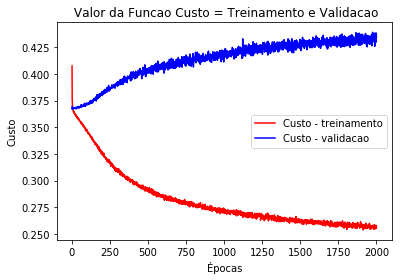

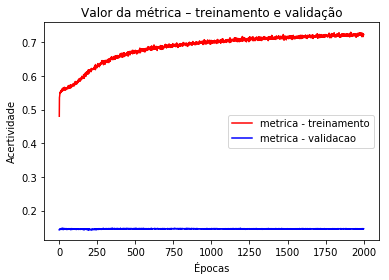

In [27]:
rna2.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna2.plot()

Confusion matrix, without normalization
[[10019   775]
 [ 1542  1473]]


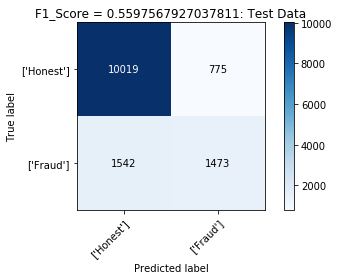

Confusion matrix, without normalization
[[9938  857]
 [1492 1523]]


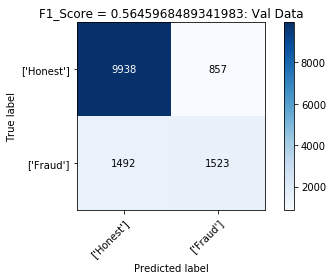

Confusion matrix, without normalization
[[49317  1055]
 [ 3491 10577]]


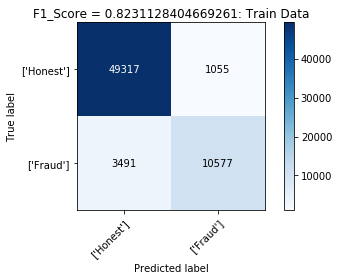

In [28]:
rna2.predict(x_data,y_data)

In [29]:
n_list3 = [100,100,1]
activation_list3 = ['tanh', 'tanh', 'sigmoid']
dropout_list3 = [0.3,0.3,0.3]

In [30]:
rna3 = new_rna()
rna3.build_model(data_shape,n_list3,activation_list3,dropout_list3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


Train on 64440 samples, validate on 13810 samples
Epoch 1/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.4062 - f1: 0.4813 - val_loss: 0.3700 - val_f1: 0.1433
Epoch 2/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3747 - f1: 0.5386 - val_loss: 0.3668 - val_f1: 0.1420
Epoch 3/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.3713 - f1: 0.5335 - val_loss: 0.3681 - val_f1: 0.1432
Epoch 4/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3678 - f1: 0.5384 - val_loss: 0.3673 - val_f1: 0.1454
Epoch 5/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.3662 - f1: 0.5451 - val_loss: 0.3670 - val_f1: 0.1410
Epoch 6/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.3668 - f1: 0.5462 - val_loss: 0.3672 - val_f1: 0.1428
Epoch 7/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.3651 - f1: 0.5492 - val_loss: 0.3676 - val_f1

Epoch 60/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3529 - f1: 0.5654 - val_loss: 0.3688 - val_f1: 0.1443
Epoch 61/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3535 - f1: 0.5678 - val_loss: 0.3684 - val_f1: 0.1420
Epoch 62/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3530 - f1: 0.5610 - val_loss: 0.3685 - val_f1: 0.1447
Epoch 63/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3527 - f1: 0.5711 - val_loss: 0.3681 - val_f1: 0.1431
Epoch 64/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.3517 - f1: 0.5689 - val_loss: 0.3688 - val_f1: 0.1441
Epoch 65/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3525 - f1: 0.5696 - val_loss: 0.3684 - val_f1: 0.1439
Epoch 66/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3522 - f1: 0.5651 - val_loss: 0.3690 - val_f1: 0.1446
Epoch 67/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.3370 - f1: 0.5861 - val_loss: 0.3729 - val_f1: 0.1453
Epoch 120/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3361 - f1: 0.5895 - val_loss: 0.3733 - val_f1: 0.1442
Epoch 121/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3370 - f1: 0.5872 - val_loss: 0.3736 - val_f1: 0.1439
Epoch 122/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.3369 - f1: 0.5882 - val_loss: 0.3715 - val_f1: 0.1434
Epoch 123/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3367 - f1: 0.5860 - val_loss: 0.3725 - val_f1: 0.1443
Epoch 124/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3369 - f1: 0.5908 - val_loss: 0.3717 - val_f1: 0.1444
Epoch 125/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3358 - f1: 0.5908 - val_loss: 0.3724 - val_f1: 0.1442
Epoch 126/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.3163 - f1: 0.6232 - val_loss: 0.3812 - val_f1: 0.1421
Epoch 179/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.3156 - f1: 0.6219 - val_loss: 0.3825 - val_f1: 0.1439
Epoch 180/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3159 - f1: 0.6281 - val_loss: 0.3818 - val_f1: 0.1419
Epoch 181/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3154 - f1: 0.6287 - val_loss: 0.3800 - val_f1: 0.1452
Epoch 182/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3136 - f1: 0.6296 - val_loss: 0.3819 - val_f1: 0.1435
Epoch 183/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3138 - f1: 0.6276 - val_loss: 0.3829 - val_f1: 0.1429
Epoch 184/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.3143 - f1: 0.6277 - val_loss: 0.3836 - val_f1: 0.1439
Epoch 185/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.2959 - f1: 0.6570 - val_loss: 0.3939 - val_f1: 0.1428
Epoch 238/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2958 - f1: 0.6572 - val_loss: 0.3941 - val_f1: 0.1424
Epoch 239/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2935 - f1: 0.6604 - val_loss: 0.3910 - val_f1: 0.1434
Epoch 240/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2945 - f1: 0.6558 - val_loss: 0.3967 - val_f1: 0.1417
Epoch 241/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2942 - f1: 0.6628 - val_loss: 0.4008 - val_f1: 0.1398
Epoch 242/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2917 - f1: 0.6635 - val_loss: 0.3944 - val_f1: 0.1421
Epoch 243/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2938 - f1: 0.6613 - val_loss: 0.3998 - val_f1: 0.1415
Epoch 244/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 49us/step - loss: 0.2780 - f1: 0.6830 - val_loss: 0.4033 - val_f1: 0.1404
Epoch 297/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2777 - f1: 0.6850 - val_loss: 0.4064 - val_f1: 0.1405
Epoch 298/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2774 - f1: 0.6907 - val_loss: 0.4081 - val_f1: 0.1398
Epoch 299/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2781 - f1: 0.6890 - val_loss: 0.4064 - val_f1: 0.1417
Epoch 300/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2780 - f1: 0.6845 - val_loss: 0.4059 - val_f1: 0.1401
Epoch 301/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2769 - f1: 0.6850 - val_loss: 0.4092 - val_f1: 0.1405
Epoch 302/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2767 - f1: 0.6846 - val_loss: 0.4075 - val_f1: 0.1397
Epoch 303/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.2640 - f1: 0.7089 - val_loss: 0.4192 - val_f1: 0.1390
Epoch 356/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.2632 - f1: 0.7067 - val_loss: 0.4180 - val_f1: 0.1388
Epoch 357/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2609 - f1: 0.7128 - val_loss: 0.4174 - val_f1: 0.1394
Epoch 358/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2639 - f1: 0.7079 - val_loss: 0.4148 - val_f1: 0.1404
Epoch 359/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2638 - f1: 0.7059 - val_loss: 0.4203 - val_f1: 0.1389
Epoch 360/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2612 - f1: 0.7131 - val_loss: 0.4207 - val_f1: 0.1383
Epoch 361/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2617 - f1: 0.7056 - val_loss: 0.4244 - val_f1: 0.1390
Epoch 362/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 50us/step - loss: 0.2504 - f1: 0.7256 - val_loss: 0.4273 - val_f1: 0.1383
Epoch 415/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2532 - f1: 0.7191 - val_loss: 0.4305 - val_f1: 0.1382
Epoch 416/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2522 - f1: 0.7205 - val_loss: 0.4316 - val_f1: 0.1380
Epoch 417/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2528 - f1: 0.7237 - val_loss: 0.4302 - val_f1: 0.1380
Epoch 418/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2526 - f1: 0.7192 - val_loss: 0.4295 - val_f1: 0.1392
Epoch 419/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2506 - f1: 0.7266 - val_loss: 0.4302 - val_f1: 0.1389
Epoch 420/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2506 - f1: 0.7228 - val_loss: 0.4304 - val_f1: 0.1384
Epoch 421/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.2416 - f1: 0.7365 - val_loss: 0.4278 - val_f1: 0.1413
Epoch 474/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2415 - f1: 0.7334 - val_loss: 0.4387 - val_f1: 0.1394
Epoch 475/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2410 - f1: 0.7355 - val_loss: 0.4366 - val_f1: 0.1397
Epoch 476/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2426 - f1: 0.7367 - val_loss: 0.4392 - val_f1: 0.1375
Epoch 477/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2412 - f1: 0.7335 - val_loss: 0.4394 - val_f1: 0.1390
Epoch 478/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2413 - f1: 0.7350 - val_loss: 0.4391 - val_f1: 0.1397
Epoch 479/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2423 - f1: 0.7348 - val_loss: 0.4403 - val_f1: 0.1384
Epoch 480/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 51us/step - loss: 0.2344 - f1: 0.7441 - val_loss: 0.4538 - val_f1: 0.1392
Epoch 533/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2336 - f1: 0.7480 - val_loss: 0.4452 - val_f1: 0.1404
Epoch 534/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2330 - f1: 0.7487 - val_loss: 0.4545 - val_f1: 0.1398
Epoch 535/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2334 - f1: 0.7481 - val_loss: 0.4458 - val_f1: 0.1401
Epoch 536/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2343 - f1: 0.7477 - val_loss: 0.4495 - val_f1: 0.1402
Epoch 537/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2353 - f1: 0.7466 - val_loss: 0.4451 - val_f1: 0.1385
Epoch 538/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2331 - f1: 0.7469 - val_loss: 0.4506 - val_f1: 0.1396
Epoch 539/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.2256 - f1: 0.7582 - val_loss: 0.4535 - val_f1: 0.1398
Epoch 592/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2259 - f1: 0.7556 - val_loss: 0.4521 - val_f1: 0.1405
Epoch 593/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2294 - f1: 0.7519 - val_loss: 0.4613 - val_f1: 0.1390
Epoch 594/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2248 - f1: 0.7533 - val_loss: 0.4507 - val_f1: 0.1396
Epoch 595/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2257 - f1: 0.7564 - val_loss: 0.4564 - val_f1: 0.1395
Epoch 596/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2276 - f1: 0.7567 - val_loss: 0.4573 - val_f1: 0.1390
Epoch 597/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2260 - f1: 0.7563 - val_loss: 0.4543 - val_f1: 0.1401
Epoch 598/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 51us/step - loss: 0.2232 - f1: 0.7589 - val_loss: 0.4587 - val_f1: 0.1391
Epoch 651/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2218 - f1: 0.7598 - val_loss: 0.4621 - val_f1: 0.1386
Epoch 652/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2228 - f1: 0.7616 - val_loss: 0.4628 - val_f1: 0.1385
Epoch 653/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2208 - f1: 0.7610 - val_loss: 0.4603 - val_f1: 0.1382
Epoch 654/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2213 - f1: 0.7589 - val_loss: 0.4621 - val_f1: 0.1390
Epoch 655/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2222 - f1: 0.7626 - val_loss: 0.4616 - val_f1: 0.1393
Epoch 656/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2203 - f1: 0.7642 - val_loss: 0.4681 - val_f1: 0.1376
Epoch 657/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.2144 - f1: 0.7742 - val_loss: 0.4629 - val_f1: 0.1391
Epoch 710/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2154 - f1: 0.7698 - val_loss: 0.4681 - val_f1: 0.1396
Epoch 711/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2184 - f1: 0.7658 - val_loss: 0.4729 - val_f1: 0.1383
Epoch 712/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2185 - f1: 0.7633 - val_loss: 0.4607 - val_f1: 0.1406
Epoch 713/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2161 - f1: 0.7661 - val_loss: 0.4662 - val_f1: 0.1395
Epoch 714/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2164 - f1: 0.7682 - val_loss: 0.4796 - val_f1: 0.1373
Epoch 715/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2160 - f1: 0.7698 - val_loss: 0.4699 - val_f1: 0.1376
Epoch 716/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 50us/step - loss: 0.2104 - f1: 0.7757 - val_loss: 0.4799 - val_f1: 0.1373
Epoch 769/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2114 - f1: 0.7710 - val_loss: 0.4759 - val_f1: 0.1383
Epoch 770/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2117 - f1: 0.7746 - val_loss: 0.4785 - val_f1: 0.1378
Epoch 771/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2128 - f1: 0.7769 - val_loss: 0.4683 - val_f1: 0.1393
Epoch 772/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2122 - f1: 0.7741 - val_loss: 0.4701 - val_f1: 0.1397
Epoch 773/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2113 - f1: 0.7763 - val_loss: 0.4809 - val_f1: 0.1373
Epoch 774/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2120 - f1: 0.7761 - val_loss: 0.4704 - val_f1: 0.1390
Epoch 775/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.2060 - f1: 0.7818 - val_loss: 0.4762 - val_f1: 0.1388
Epoch 828/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2090 - f1: 0.7771 - val_loss: 0.4791 - val_f1: 0.1392
Epoch 829/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2100 - f1: 0.7756 - val_loss: 0.4744 - val_f1: 0.1397
Epoch 830/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2089 - f1: 0.7779 - val_loss: 0.4766 - val_f1: 0.1393
Epoch 831/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2069 - f1: 0.7795 - val_loss: 0.4801 - val_f1: 0.1393
Epoch 832/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2055 - f1: 0.7805 - val_loss: 0.4801 - val_f1: 0.1405
Epoch 833/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2067 - f1: 0.7790 - val_loss: 0.4772 - val_f1: 0.1398
Epoch 834/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 50us/step - loss: 0.2085 - f1: 0.7796 - val_loss: 0.4779 - val_f1: 0.1403
Epoch 887/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2045 - f1: 0.7830 - val_loss: 0.4875 - val_f1: 0.1382
Epoch 888/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2063 - f1: 0.7809 - val_loss: 0.4770 - val_f1: 0.1401
Epoch 889/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2023 - f1: 0.7853 - val_loss: 0.4822 - val_f1: 0.1404
Epoch 890/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2047 - f1: 0.7834 - val_loss: 0.4852 - val_f1: 0.1400
Epoch 891/2000
64440/64440 [==============================] - 3s 53us/step - loss: 0.2057 - f1: 0.7834 - val_loss: 0.4805 - val_f1: 0.1394
Epoch 892/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2037 - f1: 0.7859 - val_loss: 0.4791 - val_f1: 0.1403
Epoch 893/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 48us/step - loss: 0.2032 - f1: 0.7867 - val_loss: 0.4820 - val_f1: 0.1401
Epoch 946/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2007 - f1: 0.7868 - val_loss: 0.4925 - val_f1: 0.1392
Epoch 947/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2015 - f1: 0.7837 - val_loss: 0.4906 - val_f1: 0.1393
Epoch 948/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2033 - f1: 0.7835 - val_loss: 0.4774 - val_f1: 0.1408
Epoch 949/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1993 - f1: 0.7878 - val_loss: 0.4887 - val_f1: 0.1401
Epoch 950/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2026 - f1: 0.7852 - val_loss: 0.4857 - val_f1: 0.1399
Epoch 951/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2004 - f1: 0.7898 - val_loss: 0.4904 - val_f1: 0.1399
Epoch 952/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 48us/step - loss: 0.1990 - f1: 0.7913 - val_loss: 0.4968 - val_f1: 0.1380
Epoch 1005/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1984 - f1: 0.7920 - val_loss: 0.4938 - val_f1: 0.1393
Epoch 1006/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1984 - f1: 0.7906 - val_loss: 0.4885 - val_f1: 0.1396
Epoch 1007/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2001 - f1: 0.7891 - val_loss: 0.4854 - val_f1: 0.1405
Epoch 1008/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.2022 - f1: 0.7850 - val_loss: 0.4843 - val_f1: 0.1395
Epoch 1009/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1986 - f1: 0.7893 - val_loss: 0.4902 - val_f1: 0.1397
Epoch 1010/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.1981 - f1: 0.7908 - val_loss: 0.4934 - val_f1: 0.1387
Epoch 1011/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 50us/step - loss: 0.1951 - f1: 0.7958 - val_loss: 0.4953 - val_f1: 0.1389
Epoch 1063/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.1983 - f1: 0.7907 - val_loss: 0.4917 - val_f1: 0.1392
Epoch 1064/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1996 - f1: 0.7905 - val_loss: 0.4931 - val_f1: 0.1392
Epoch 1065/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1947 - f1: 0.7936 - val_loss: 0.4922 - val_f1: 0.1395
Epoch 1066/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1970 - f1: 0.7946 - val_loss: 0.4888 - val_f1: 0.1391
Epoch 1067/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.1947 - f1: 0.7936 - val_loss: 0.4982 - val_f1: 0.1389
Epoch 1068/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.1952 - f1: 0.7938 - val_loss: 0.4977 - val_f1: 0.1390
Epoch 1069/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1977 - f1: 0.7910 - val_loss: 0.4906 - val_f1: 0.1392
Epoch 1121/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1948 - f1: 0.7907 - val_loss: 0.4965 - val_f1: 0.1377
Epoch 1122/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1942 - f1: 0.7938 - val_loss: 0.4986 - val_f1: 0.1379
Epoch 1123/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1931 - f1: 0.7957 - val_loss: 0.4970 - val_f1: 0.1384
Epoch 1124/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.1932 - f1: 0.7984 - val_loss: 0.4997 - val_f1: 0.1381
Epoch 1125/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.1924 - f1: 0.7968 - val_loss: 0.4974 - val_f1: 0.1382
Epoch 1126/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1946 - f1: 0.7991 - val_loss: 0.4966 - val_f1: 0.1393
Epoch 1127/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1896 - f1: 0.7972 - val_loss: 0.4990 - val_f1: 0.1387
Epoch 1179/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.1909 - f1: 0.7960 - val_loss: 0.5018 - val_f1: 0.1386
Epoch 1180/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1941 - f1: 0.7922 - val_loss: 0.5060 - val_f1: 0.1378
Epoch 1181/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1938 - f1: 0.7976 - val_loss: 0.4989 - val_f1: 0.1383
Epoch 1182/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.1916 - f1: 0.7983 - val_loss: 0.5029 - val_f1: 0.1378
Epoch 1183/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1927 - f1: 0.7982 - val_loss: 0.4999 - val_f1: 0.1378
Epoch 1184/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1929 - f1: 0.7979 - val_loss: 0.5055 - val_f1: 0.1380
Epoch 1185/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 51us/step - loss: 0.1875 - f1: 0.8022 - val_loss: 0.5050 - val_f1: 0.1381
Epoch 1237/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.1905 - f1: 0.8007 - val_loss: 0.4952 - val_f1: 0.1390
Epoch 1238/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1884 - f1: 0.8021 - val_loss: 0.4967 - val_f1: 0.1390
Epoch 1239/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1890 - f1: 0.8051 - val_loss: 0.5063 - val_f1: 0.1384
Epoch 1240/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1862 - f1: 0.8066 - val_loss: 0.5162 - val_f1: 0.1387
Epoch 1241/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.1908 - f1: 0.8006 - val_loss: 0.5071 - val_f1: 0.1385
Epoch 1242/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1885 - f1: 0.8015 - val_loss: 0.5041 - val_f1: 0.1384
Epoch 1243/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.1885 - f1: 0.8026 - val_loss: 0.5062 - val_f1: 0.1383
Epoch 1295/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.1848 - f1: 0.8033 - val_loss: 0.5137 - val_f1: 0.1389
Epoch 1296/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1846 - f1: 0.8078 - val_loss: 0.5117 - val_f1: 0.1391
Epoch 1297/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1874 - f1: 0.8052 - val_loss: 0.5108 - val_f1: 0.1384
Epoch 1298/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1881 - f1: 0.7995 - val_loss: 0.5126 - val_f1: 0.1386
Epoch 1299/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1894 - f1: 0.8025 - val_loss: 0.5064 - val_f1: 0.1387
Epoch 1300/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.1895 - f1: 0.8027 - val_loss: 0.5077 - val_f1: 0.1384
Epoch 1301/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1872 - f1: 0.8046 - val_loss: 0.5097 - val_f1: 0.1380
Epoch 1353/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1886 - f1: 0.8066 - val_loss: 0.5042 - val_f1: 0.1387
Epoch 1354/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1880 - f1: 0.8036 - val_loss: 0.5035 - val_f1: 0.1388
Epoch 1355/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1857 - f1: 0.8067 - val_loss: 0.5105 - val_f1: 0.1377
Epoch 1356/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.1862 - f1: 0.8020 - val_loss: 0.5083 - val_f1: 0.1380
Epoch 1357/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.1850 - f1: 0.8078 - val_loss: 0.5056 - val_f1: 0.1384
Epoch 1358/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1871 - f1: 0.8007 - val_loss: 0.5150 - val_f1: 0.1368
Epoch 1359/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.1830 - f1: 0.8109 - val_loss: 0.5143 - val_f1: 0.1382
Epoch 1411/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1858 - f1: 0.8051 - val_loss: 0.5154 - val_f1: 0.1379
Epoch 1412/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1832 - f1: 0.8091 - val_loss: 0.5103 - val_f1: 0.1386
Epoch 1413/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1826 - f1: 0.8094 - val_loss: 0.5146 - val_f1: 0.1389
Epoch 1414/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1850 - f1: 0.8044 - val_loss: 0.5063 - val_f1: 0.1395
Epoch 1415/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1867 - f1: 0.8053 - val_loss: 0.5156 - val_f1: 0.1381
Epoch 1416/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1855 - f1: 0.8073 - val_loss: 0.5090 - val_f1: 0.1386
Epoch 1417/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.1855 - f1: 0.8071 - val_loss: 0.5141 - val_f1: 0.1389
Epoch 1469/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1832 - f1: 0.8069 - val_loss: 0.5101 - val_f1: 0.1400
Epoch 1470/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1825 - f1: 0.8092 - val_loss: 0.5200 - val_f1: 0.1386
Epoch 1471/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1829 - f1: 0.8066 - val_loss: 0.5254 - val_f1: 0.1385
Epoch 1472/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1836 - f1: 0.8058 - val_loss: 0.5152 - val_f1: 0.1391
Epoch 1473/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1816 - f1: 0.8062 - val_loss: 0.5189 - val_f1: 0.1388
Epoch 1474/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1833 - f1: 0.8073 - val_loss: 0.5066 - val_f1: 0.1395
Epoch 1475/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.1823 - f1: 0.8092 - val_loss: 0.5181 - val_f1: 0.1390
Epoch 1527/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1825 - f1: 0.8091 - val_loss: 0.5174 - val_f1: 0.1383
Epoch 1528/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1798 - f1: 0.8136 - val_loss: 0.5240 - val_f1: 0.1377
Epoch 1529/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1808 - f1: 0.8101 - val_loss: 0.5245 - val_f1: 0.1377
Epoch 1530/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1790 - f1: 0.8125 - val_loss: 0.5229 - val_f1: 0.1379
Epoch 1531/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1817 - f1: 0.8079 - val_loss: 0.5213 - val_f1: 0.1379
Epoch 1532/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1860 - f1: 0.8056 - val_loss: 0.5143 - val_f1: 0.1384
Epoch 1533/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.1810 - f1: 0.8119 - val_loss: 0.5244 - val_f1: 0.1376
Epoch 1585/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1810 - f1: 0.8108 - val_loss: 0.5198 - val_f1: 0.1385
Epoch 1586/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1820 - f1: 0.8109 - val_loss: 0.5142 - val_f1: 0.1392
Epoch 1587/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1796 - f1: 0.8106 - val_loss: 0.5097 - val_f1: 0.1392
Epoch 1588/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1810 - f1: 0.8099 - val_loss: 0.5161 - val_f1: 0.1383
Epoch 1589/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1796 - f1: 0.8133 - val_loss: 0.5120 - val_f1: 0.1393
Epoch 1590/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1798 - f1: 0.8150 - val_loss: 0.5231 - val_f1: 0.1384
Epoch 1591/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1809 - f1: 0.8116 - val_loss: 0.5254 - val_f1: 0.1372
Epoch 1643/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1796 - f1: 0.8117 - val_loss: 0.5227 - val_f1: 0.1380
Epoch 1644/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1814 - f1: 0.8075 - val_loss: 0.5234 - val_f1: 0.1382
Epoch 1645/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1802 - f1: 0.8105 - val_loss: 0.5253 - val_f1: 0.1381
Epoch 1646/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1797 - f1: 0.8152 - val_loss: 0.5168 - val_f1: 0.1379
Epoch 1647/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1785 - f1: 0.8134 - val_loss: 0.5256 - val_f1: 0.1390
Epoch 1648/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1802 - f1: 0.8129 - val_loss: 0.5174 - val_f1: 0.1388
Epoch 1649/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.1797 - f1: 0.8160 - val_loss: 0.5170 - val_f1: 0.1378
Epoch 1701/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1795 - f1: 0.8153 - val_loss: 0.5182 - val_f1: 0.1387
Epoch 1702/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1801 - f1: 0.8132 - val_loss: 0.5059 - val_f1: 0.1397
Epoch 1703/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1777 - f1: 0.8188 - val_loss: 0.5246 - val_f1: 0.1387
Epoch 1704/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1765 - f1: 0.8175 - val_loss: 0.5216 - val_f1: 0.1388
Epoch 1705/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.1785 - f1: 0.8143 - val_loss: 0.5201 - val_f1: 0.1383
Epoch 1706/2000
64440/64440 [==============================] - 3s 44us/step - loss: 0.1750 - f1: 0.8180 - val_loss: 0.5117 - val_f1: 0.1392
Epoch 1707/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1771 - f1: 0.8197 - val_loss: 0.5163 - val_f1: 0.1382
Epoch 1759/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1784 - f1: 0.8112 - val_loss: 0.5278 - val_f1: 0.1389
Epoch 1760/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1749 - f1: 0.8170 - val_loss: 0.5277 - val_f1: 0.1381
Epoch 1761/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1780 - f1: 0.8135 - val_loss: 0.5211 - val_f1: 0.1380
Epoch 1762/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1762 - f1: 0.8133 - val_loss: 0.5248 - val_f1: 0.1395
Epoch 1763/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1751 - f1: 0.8169 - val_loss: 0.5175 - val_f1: 0.1395
Epoch 1764/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1806 - f1: 0.8129 - val_loss: 0.5251 - val_f1: 0.1391
Epoch 1765/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1730 - f1: 0.8206 - val_loss: 0.5255 - val_f1: 0.1383
Epoch 1817/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.1770 - f1: 0.8197 - val_loss: 0.5271 - val_f1: 0.1380
Epoch 1818/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1781 - f1: 0.8123 - val_loss: 0.5221 - val_f1: 0.1391
Epoch 1819/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1735 - f1: 0.8199 - val_loss: 0.5211 - val_f1: 0.1395
Epoch 1820/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1768 - f1: 0.8192 - val_loss: 0.5207 - val_f1: 0.1379
Epoch 1821/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1810 - f1: 0.8116 - val_loss: 0.5243 - val_f1: 0.1376
Epoch 1822/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.1746 - f1: 0.8153 - val_loss: 0.5285 - val_f1: 0.1386
Epoch 1823/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1767 - f1: 0.8164 - val_loss: 0.5298 - val_f1: 0.1380
Epoch 1875/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1750 - f1: 0.8196 - val_loss: 0.5216 - val_f1: 0.1390
Epoch 1876/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1736 - f1: 0.8207 - val_loss: 0.5249 - val_f1: 0.1389
Epoch 1877/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.1752 - f1: 0.8177 - val_loss: 0.5306 - val_f1: 0.1379
Epoch 1878/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1771 - f1: 0.8160 - val_loss: 0.5131 - val_f1: 0.1396
Epoch 1879/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1749 - f1: 0.8181 - val_loss: 0.5303 - val_f1: 0.1383
Epoch 1880/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1752 - f1: 0.8173 - val_loss: 0.5250 - val_f1: 0.1378
Epoch 1881/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 47us/step - loss: 0.1746 - f1: 0.8199 - val_loss: 0.5332 - val_f1: 0.1382
Epoch 1933/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.1757 - f1: 0.8176 - val_loss: 0.5260 - val_f1: 0.1387
Epoch 1934/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1731 - f1: 0.8224 - val_loss: 0.5316 - val_f1: 0.1389
Epoch 1935/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1740 - f1: 0.8216 - val_loss: 0.5204 - val_f1: 0.1381
Epoch 1936/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1761 - f1: 0.8193 - val_loss: 0.5351 - val_f1: 0.1367
Epoch 1937/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1731 - f1: 0.8164 - val_loss: 0.5322 - val_f1: 0.1377
Epoch 1938/2000
64440/64440 [==============================] - 3s 43us/step - loss: 0.1734 - f1: 0.8211 - val_loss: 0.5225 - val_f1: 0.1391
Epoch 1939/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 50us/step - loss: 0.1713 - f1: 0.8216 - val_loss: 0.5376 - val_f1: 0.1369
Epoch 1991/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1723 - f1: 0.8208 - val_loss: 0.5306 - val_f1: 0.1386
Epoch 1992/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1741 - f1: 0.8189 - val_loss: 0.5311 - val_f1: 0.1376
Epoch 1993/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1755 - f1: 0.8200 - val_loss: 0.5160 - val_f1: 0.1391
Epoch 1994/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.1752 - f1: 0.8193 - val_loss: 0.5297 - val_f1: 0.1379
Epoch 1995/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.1741 - f1: 0.8191 - val_loss: 0.5321 - val_f1: 0.1384
Epoch 1996/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.1743 - f1: 0.8184 - val_loss: 0.5209 - val_f1: 0.1391
Epoch 1997/2000
64440/64440 [=======

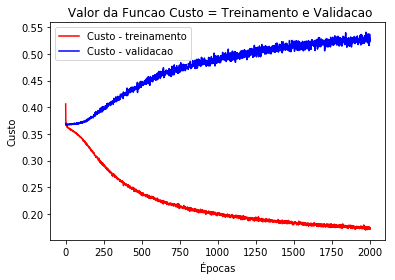

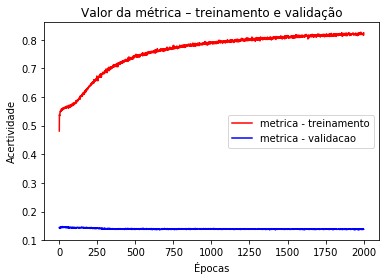

In [31]:
rna3.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna3.plot()

Confusion matrix, without normalization
[[10116   678]
 [ 1641  1374]]


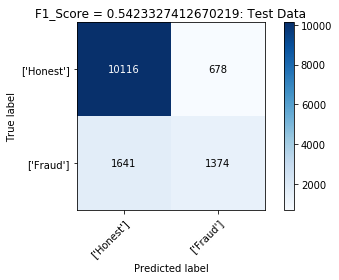

Confusion matrix, without normalization
[[10084   711]
 [ 1614  1401]]


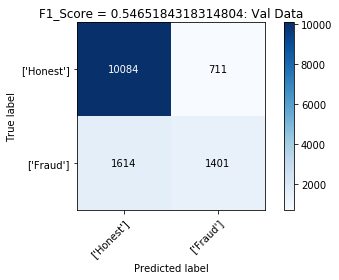

Confusion matrix, without normalization
[[50296    76]
 [ 1273 12795]]


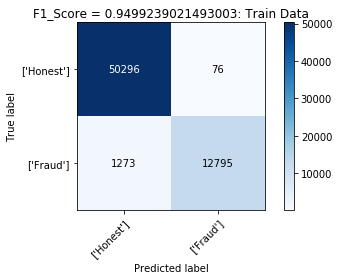

In [32]:
rna3.predict(x_data,y_data)

In [33]:
n_list4 = [50,50,50,1]
activation_list4 = ['tanh','tanh','tanh','sigmoid']
dropout_list4 = [0.3,0.3,0.3]

In [34]:
rna4 = new_rna()
rna4.build_model(data_shape,n_list4,activation_list4,dropout_list4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total para

Train on 64440 samples, validate on 13810 samples
Epoch 1/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.4120 - f1: 0.4740 - val_loss: 0.3715 - val_f1: 0.1452
Epoch 2/2000
64440/64440 [==============================] - 3s 45us/step - loss: 0.3813 - f1: 0.5308 - val_loss: 0.3700 - val_f1: 0.1484
Epoch 3/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3772 - f1: 0.5424 - val_loss: 0.3700 - val_f1: 0.1444
Epoch 4/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.3743 - f1: 0.5471 - val_loss: 0.3707 - val_f1: 0.1478
Epoch 5/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3724 - f1: 0.5518 - val_loss: 0.3711 - val_f1: 0.1511
Epoch 6/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3716 - f1: 0.5522 - val_loss: 0.3694 - val_f1: 0.1482
Epoch 7/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3698 - f1: 0.5586 - val_loss: 0.3697 - val_f1

64440/64440 [==============================] - 3s 46us/step - loss: 0.3557 - f1: 0.5717 - val_loss: 0.3738 - val_f1: 0.1476
Epoch 61/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3553 - f1: 0.5713 - val_loss: 0.3739 - val_f1: 0.1466
Epoch 62/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.3555 - f1: 0.5659 - val_loss: 0.3753 - val_f1: 0.1479
Epoch 63/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3551 - f1: 0.5718 - val_loss: 0.3742 - val_f1: 0.1476
Epoch 64/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3546 - f1: 0.5722 - val_loss: 0.3745 - val_f1: 0.1471
Epoch 65/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3551 - f1: 0.5700 - val_loss: 0.3744 - val_f1: 0.1486
Epoch 66/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3544 - f1: 0.5690 - val_loss: 0.3740 - val_f1: 0.1473
Epoch 67/2000
64440/64440 [=====================

64440/64440 [==============================] - 3s 50us/step - loss: 0.3453 - f1: 0.5814 - val_loss: 0.3781 - val_f1: 0.1479
Epoch 120/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3442 - f1: 0.5852 - val_loss: 0.3804 - val_f1: 0.1477
Epoch 121/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3451 - f1: 0.5863 - val_loss: 0.3781 - val_f1: 0.1471
Epoch 122/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3446 - f1: 0.5857 - val_loss: 0.3785 - val_f1: 0.1481
Epoch 123/2000
64440/64440 [==============================] - 3s 46us/step - loss: 0.3435 - f1: 0.5860 - val_loss: 0.3796 - val_f1: 0.1485
Epoch 124/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3443 - f1: 0.5852 - val_loss: 0.3791 - val_f1: 0.1488
Epoch 125/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.3427 - f1: 0.5889 - val_loss: 0.3783 - val_f1: 0.1466
Epoch 126/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 47us/step - loss: 0.3330 - f1: 0.6037 - val_loss: 0.3835 - val_f1: 0.1484
Epoch 179/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3338 - f1: 0.6058 - val_loss: 0.3816 - val_f1: 0.1462
Epoch 180/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3343 - f1: 0.6023 - val_loss: 0.3828 - val_f1: 0.1474
Epoch 181/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.3337 - f1: 0.6043 - val_loss: 0.3864 - val_f1: 0.1468
Epoch 182/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3329 - f1: 0.6088 - val_loss: 0.3842 - val_f1: 0.1477
Epoch 183/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.3332 - f1: 0.6088 - val_loss: 0.3849 - val_f1: 0.1473
Epoch 184/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3326 - f1: 0.6084 - val_loss: 0.3823 - val_f1: 0.1465
Epoch 185/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 51us/step - loss: 0.3241 - f1: 0.6236 - val_loss: 0.3913 - val_f1: 0.1469
Epoch 238/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3247 - f1: 0.6233 - val_loss: 0.3934 - val_f1: 0.1471
Epoch 239/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3247 - f1: 0.6172 - val_loss: 0.3892 - val_f1: 0.1474
Epoch 240/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3226 - f1: 0.6275 - val_loss: 0.3885 - val_f1: 0.1473
Epoch 241/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3243 - f1: 0.6217 - val_loss: 0.3919 - val_f1: 0.1481
Epoch 242/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.3250 - f1: 0.6209 - val_loss: 0.3908 - val_f1: 0.1477
Epoch 243/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3228 - f1: 0.6271 - val_loss: 0.3901 - val_f1: 0.1469
Epoch 244/2000
64440/64440 [==============

Epoch 296/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3153 - f1: 0.6367 - val_loss: 0.3925 - val_f1: 0.1466
Epoch 297/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3142 - f1: 0.6369 - val_loss: 0.3945 - val_f1: 0.1468
Epoch 298/2000
64440/64440 [==============================] - 3s 53us/step - loss: 0.3160 - f1: 0.6367 - val_loss: 0.3934 - val_f1: 0.1466
Epoch 299/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3149 - f1: 0.6355 - val_loss: 0.3935 - val_f1: 0.1467
Epoch 300/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.3132 - f1: 0.6408 - val_loss: 0.3935 - val_f1: 0.1460
Epoch 301/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3148 - f1: 0.6383 - val_loss: 0.3940 - val_f1: 0.1471
Epoch 302/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.3140 - f1: 0.6391 - val_loss: 0.3950 - val_f1: 0.1472
Epoch 303/2000
64440/64440 

Epoch 355/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3082 - f1: 0.6487 - val_loss: 0.4033 - val_f1: 0.1468
Epoch 356/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.3085 - f1: 0.6506 - val_loss: 0.4030 - val_f1: 0.1468
Epoch 357/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3091 - f1: 0.6496 - val_loss: 0.4030 - val_f1: 0.1473
Epoch 358/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.3089 - f1: 0.6462 - val_loss: 0.3977 - val_f1: 0.1463
Epoch 359/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3097 - f1: 0.6487 - val_loss: 0.3943 - val_f1: 0.1456
Epoch 360/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3085 - f1: 0.6467 - val_loss: 0.4023 - val_f1: 0.1476
Epoch 361/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3076 - f1: 0.6493 - val_loss: 0.4020 - val_f1: 0.1474
Epoch 362/2000
64440/64440 

Epoch 414/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.3033 - f1: 0.6603 - val_loss: 0.4039 - val_f1: 0.1467
Epoch 415/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3033 - f1: 0.6562 - val_loss: 0.4022 - val_f1: 0.1464
Epoch 416/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3021 - f1: 0.6518 - val_loss: 0.4012 - val_f1: 0.1464
Epoch 417/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3028 - f1: 0.6575 - val_loss: 0.4004 - val_f1: 0.1446
Epoch 418/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3012 - f1: 0.6572 - val_loss: 0.4019 - val_f1: 0.1462
Epoch 419/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.3030 - f1: 0.6579 - val_loss: 0.4045 - val_f1: 0.1470
Epoch 420/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3033 - f1: 0.6538 - val_loss: 0.4029 - val_f1: 0.1467
Epoch 421/2000
64440/64440 

Epoch 473/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2989 - f1: 0.6632 - val_loss: 0.4061 - val_f1: 0.1461
Epoch 474/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2972 - f1: 0.6659 - val_loss: 0.4076 - val_f1: 0.1467
Epoch 475/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.3000 - f1: 0.6633 - val_loss: 0.4050 - val_f1: 0.1457
Epoch 476/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2984 - f1: 0.6599 - val_loss: 0.4072 - val_f1: 0.1461
Epoch 477/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2986 - f1: 0.6642 - val_loss: 0.4074 - val_f1: 0.1467
Epoch 478/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2975 - f1: 0.6657 - val_loss: 0.4129 - val_f1: 0.1471
Epoch 479/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.2986 - f1: 0.6658 - val_loss: 0.4096 - val_f1: 0.1465
Epoch 480/2000
64440/64440 

Epoch 532/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2956 - f1: 0.6689 - val_loss: 0.4098 - val_f1: 0.1464
Epoch 533/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2938 - f1: 0.6732 - val_loss: 0.4097 - val_f1: 0.1463
Epoch 534/2000
64440/64440 [==============================] - 3s 47us/step - loss: 0.2932 - f1: 0.6724 - val_loss: 0.4105 - val_f1: 0.1459
Epoch 535/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2939 - f1: 0.6747 - val_loss: 0.4152 - val_f1: 0.1463
Epoch 536/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2927 - f1: 0.6747 - val_loss: 0.4113 - val_f1: 0.1459
Epoch 537/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2937 - f1: 0.6727 - val_loss: 0.4145 - val_f1: 0.1462
Epoch 538/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2924 - f1: 0.6754 - val_loss: 0.4101 - val_f1: 0.1454
Epoch 539/2000
64440/64440 

Epoch 591/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2910 - f1: 0.6727 - val_loss: 0.4187 - val_f1: 0.1477
Epoch 592/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2898 - f1: 0.6776 - val_loss: 0.4146 - val_f1: 0.1454
Epoch 593/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2901 - f1: 0.6785 - val_loss: 0.4106 - val_f1: 0.1456
Epoch 594/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2896 - f1: 0.6757 - val_loss: 0.4132 - val_f1: 0.1468
Epoch 595/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2908 - f1: 0.6752 - val_loss: 0.4178 - val_f1: 0.1465
Epoch 596/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2913 - f1: 0.6756 - val_loss: 0.4115 - val_f1: 0.1471
Epoch 597/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2920 - f1: 0.6751 - val_loss: 0.4124 - val_f1: 0.1468
Epoch 598/2000
64440/64440 

64440/64440 [==============================] - 3s 48us/step - loss: 0.2879 - f1: 0.6796 - val_loss: 0.4147 - val_f1: 0.1462
Epoch 650/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2882 - f1: 0.6826 - val_loss: 0.4145 - val_f1: 0.1458
Epoch 651/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2887 - f1: 0.6817 - val_loss: 0.4174 - val_f1: 0.1460
Epoch 652/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2895 - f1: 0.6747 - val_loss: 0.4116 - val_f1: 0.1458
Epoch 653/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2884 - f1: 0.6827 - val_loss: 0.4179 - val_f1: 0.1459
Epoch 654/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2897 - f1: 0.6776 - val_loss: 0.4129 - val_f1: 0.1455
Epoch 655/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2878 - f1: 0.6785 - val_loss: 0.4148 - val_f1: 0.1466
Epoch 656/2000
64440/64440 [==============

64440/64440 [==============================] - 3s 48us/step - loss: 0.2860 - f1: 0.6823 - val_loss: 0.4204 - val_f1: 0.1463
Epoch 709/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2879 - f1: 0.6828 - val_loss: 0.4192 - val_f1: 0.1468
Epoch 710/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2865 - f1: 0.6824 - val_loss: 0.4199 - val_f1: 0.1459
Epoch 711/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2866 - f1: 0.6796 - val_loss: 0.4184 - val_f1: 0.1468
Epoch 712/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2874 - f1: 0.6819 - val_loss: 0.4195 - val_f1: 0.1468
Epoch 713/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2861 - f1: 0.6818 - val_loss: 0.4185 - val_f1: 0.1466
Epoch 714/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2841 - f1: 0.6859 - val_loss: 0.4258 - val_f1: 0.1469
Epoch 715/2000
64440/64440 [==============

Epoch 767/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2840 - f1: 0.6859 - val_loss: 0.4236 - val_f1: 0.1453
Epoch 768/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2844 - f1: 0.6852 - val_loss: 0.4225 - val_f1: 0.1458
Epoch 769/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2835 - f1: 0.6879 - val_loss: 0.4162 - val_f1: 0.1457
Epoch 770/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2833 - f1: 0.6865 - val_loss: 0.4193 - val_f1: 0.1459
Epoch 771/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2840 - f1: 0.6829 - val_loss: 0.4214 - val_f1: 0.1450
Epoch 772/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2818 - f1: 0.6877 - val_loss: 0.4188 - val_f1: 0.1456
Epoch 773/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2827 - f1: 0.6868 - val_loss: 0.4182 - val_f1: 0.1463
Epoch 774/2000
64440/64440 

Epoch 826/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2815 - f1: 0.6914 - val_loss: 0.4203 - val_f1: 0.1443
Epoch 827/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2781 - f1: 0.6931 - val_loss: 0.4230 - val_f1: 0.1453
Epoch 828/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2818 - f1: 0.6887 - val_loss: 0.4222 - val_f1: 0.1460
Epoch 829/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2803 - f1: 0.6917 - val_loss: 0.4312 - val_f1: 0.1460
Epoch 830/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2839 - f1: 0.6921 - val_loss: 0.4212 - val_f1: 0.1450
Epoch 831/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2793 - f1: 0.6928 - val_loss: 0.4275 - val_f1: 0.1459
Epoch 832/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2822 - f1: 0.6919 - val_loss: 0.4277 - val_f1: 0.1452
Epoch 833/2000
64440/64440 

Epoch 885/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2785 - f1: 0.6955 - val_loss: 0.4222 - val_f1: 0.1457
Epoch 886/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2804 - f1: 0.6916 - val_loss: 0.4275 - val_f1: 0.1449
Epoch 887/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2779 - f1: 0.6953 - val_loss: 0.4261 - val_f1: 0.1456
Epoch 888/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2805 - f1: 0.6924 - val_loss: 0.4297 - val_f1: 0.1465
Epoch 889/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2815 - f1: 0.6941 - val_loss: 0.4250 - val_f1: 0.1464
Epoch 890/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2794 - f1: 0.6928 - val_loss: 0.4213 - val_f1: 0.1450
Epoch 891/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2791 - f1: 0.6927 - val_loss: 0.4243 - val_f1: 0.1459
Epoch 892/2000
64440/64440 

Epoch 944/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2770 - f1: 0.6974 - val_loss: 0.4225 - val_f1: 0.1447
Epoch 945/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2780 - f1: 0.6931 - val_loss: 0.4345 - val_f1: 0.1460
Epoch 946/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2786 - f1: 0.6944 - val_loss: 0.4314 - val_f1: 0.1460
Epoch 947/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2786 - f1: 0.6959 - val_loss: 0.4234 - val_f1: 0.1454
Epoch 948/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2781 - f1: 0.6979 - val_loss: 0.4251 - val_f1: 0.1455
Epoch 949/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2780 - f1: 0.6954 - val_loss: 0.4266 - val_f1: 0.1456
Epoch 950/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2794 - f1: 0.6965 - val_loss: 0.4230 - val_f1: 0.1452
Epoch 951/2000
64440/64440 

Epoch 1003/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2774 - f1: 0.6951 - val_loss: 0.4274 - val_f1: 0.1449
Epoch 1004/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2770 - f1: 0.6943 - val_loss: 0.4302 - val_f1: 0.1459
Epoch 1005/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2748 - f1: 0.6961 - val_loss: 0.4290 - val_f1: 0.1459
Epoch 1006/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2762 - f1: 0.6982 - val_loss: 0.4214 - val_f1: 0.1453
Epoch 1007/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2751 - f1: 0.7008 - val_loss: 0.4225 - val_f1: 0.1449
Epoch 1008/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2745 - f1: 0.7019 - val_loss: 0.4277 - val_f1: 0.1447
Epoch 1009/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2773 - f1: 0.6934 - val_loss: 0.4233 - val_f1: 0.1445
Epoch 1010/2000
6444

64440/64440 [==============================] - 3s 48us/step - loss: 0.2732 - f1: 0.7027 - val_loss: 0.4355 - val_f1: 0.1469
Epoch 1062/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2748 - f1: 0.7052 - val_loss: 0.4319 - val_f1: 0.1463
Epoch 1063/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2727 - f1: 0.7053 - val_loss: 0.4310 - val_f1: 0.1449
Epoch 1064/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2760 - f1: 0.7034 - val_loss: 0.4301 - val_f1: 0.1458
Epoch 1065/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2746 - f1: 0.7029 - val_loss: 0.4317 - val_f1: 0.1461
Epoch 1066/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2769 - f1: 0.6986 - val_loss: 0.4282 - val_f1: 0.1451
Epoch 1067/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2751 - f1: 0.7009 - val_loss: 0.4289 - val_f1: 0.1464
Epoch 1068/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2741 - f1: 0.7061 - val_loss: 0.4346 - val_f1: 0.1453
Epoch 1120/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2735 - f1: 0.7025 - val_loss: 0.4346 - val_f1: 0.1455
Epoch 1121/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2731 - f1: 0.7053 - val_loss: 0.4261 - val_f1: 0.1455
Epoch 1122/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2728 - f1: 0.7023 - val_loss: 0.4289 - val_f1: 0.1448
Epoch 1123/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2740 - f1: 0.7020 - val_loss: 0.4317 - val_f1: 0.1466
Epoch 1124/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2751 - f1: 0.7041 - val_loss: 0.4342 - val_f1: 0.1463
Epoch 1125/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2744 - f1: 0.7038 - val_loss: 0.4333 - val_f1: 0.1458
Epoch 1126/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2710 - f1: 0.7039 - val_loss: 0.4304 - val_f1: 0.1455
Epoch 1178/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2739 - f1: 0.7005 - val_loss: 0.4265 - val_f1: 0.1455
Epoch 1179/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2729 - f1: 0.7055 - val_loss: 0.4297 - val_f1: 0.1457
Epoch 1180/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2728 - f1: 0.7055 - val_loss: 0.4364 - val_f1: 0.1450
Epoch 1181/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2744 - f1: 0.6997 - val_loss: 0.4307 - val_f1: 0.1446
Epoch 1182/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2742 - f1: 0.6997 - val_loss: 0.4326 - val_f1: 0.1456
Epoch 1183/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2726 - f1: 0.7044 - val_loss: 0.4350 - val_f1: 0.1460
Epoch 1184/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 52us/step - loss: 0.2707 - f1: 0.7046 - val_loss: 0.4358 - val_f1: 0.1467
Epoch 1236/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2694 - f1: 0.7099 - val_loss: 0.4356 - val_f1: 0.1460
Epoch 1237/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2731 - f1: 0.7058 - val_loss: 0.4291 - val_f1: 0.1452
Epoch 1238/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2731 - f1: 0.7069 - val_loss: 0.4322 - val_f1: 0.1454
Epoch 1239/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2714 - f1: 0.7047 - val_loss: 0.4339 - val_f1: 0.1458
Epoch 1240/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2703 - f1: 0.7103 - val_loss: 0.4349 - val_f1: 0.1463
Epoch 1241/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2710 - f1: 0.7071 - val_loss: 0.4321 - val_f1: 0.1460
Epoch 1242/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2699 - f1: 0.7042 - val_loss: 0.4369 - val_f1: 0.1463
Epoch 1294/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2705 - f1: 0.7073 - val_loss: 0.4296 - val_f1: 0.1449
Epoch 1295/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2696 - f1: 0.7041 - val_loss: 0.4381 - val_f1: 0.1467
Epoch 1296/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2699 - f1: 0.7113 - val_loss: 0.4315 - val_f1: 0.1458
Epoch 1297/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2720 - f1: 0.7057 - val_loss: 0.4394 - val_f1: 0.1465
Epoch 1298/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2698 - f1: 0.7084 - val_loss: 0.4349 - val_f1: 0.1449
Epoch 1299/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2688 - f1: 0.7076 - val_loss: 0.4375 - val_f1: 0.1455
Epoch 1300/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2698 - f1: 0.7070 - val_loss: 0.4342 - val_f1: 0.1451
Epoch 1352/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2674 - f1: 0.7148 - val_loss: 0.4295 - val_f1: 0.1451
Epoch 1353/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2696 - f1: 0.7116 - val_loss: 0.4324 - val_f1: 0.1451
Epoch 1354/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2690 - f1: 0.7135 - val_loss: 0.4386 - val_f1: 0.1454
Epoch 1355/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2704 - f1: 0.7071 - val_loss: 0.4382 - val_f1: 0.1457
Epoch 1356/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2679 - f1: 0.7132 - val_loss: 0.4316 - val_f1: 0.1452
Epoch 1357/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2707 - f1: 0.7087 - val_loss: 0.4363 - val_f1: 0.1455
Epoch 1358/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 51us/step - loss: 0.2683 - f1: 0.7130 - val_loss: 0.4333 - val_f1: 0.1456
Epoch 1410/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2680 - f1: 0.7105 - val_loss: 0.4385 - val_f1: 0.1466
Epoch 1411/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2680 - f1: 0.7093 - val_loss: 0.4392 - val_f1: 0.1457
Epoch 1412/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2675 - f1: 0.7105 - val_loss: 0.4342 - val_f1: 0.1447
Epoch 1413/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2672 - f1: 0.7101 - val_loss: 0.4350 - val_f1: 0.1458
Epoch 1414/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2685 - f1: 0.7127 - val_loss: 0.4377 - val_f1: 0.1452
Epoch 1415/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2693 - f1: 0.7071 - val_loss: 0.4355 - val_f1: 0.1459
Epoch 1416/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2671 - f1: 0.7111 - val_loss: 0.4309 - val_f1: 0.1447
Epoch 1468/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2678 - f1: 0.7090 - val_loss: 0.4320 - val_f1: 0.1464
Epoch 1469/2000
64440/64440 [==============================] - 3s 53us/step - loss: 0.2662 - f1: 0.7125 - val_loss: 0.4363 - val_f1: 0.1457
Epoch 1470/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2666 - f1: 0.7128 - val_loss: 0.4367 - val_f1: 0.1454
Epoch 1471/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2673 - f1: 0.7107 - val_loss: 0.4319 - val_f1: 0.1451
Epoch 1472/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2665 - f1: 0.7147 - val_loss: 0.4357 - val_f1: 0.1450
Epoch 1473/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2680 - f1: 0.7126 - val_loss: 0.4319 - val_f1: 0.1448
Epoch 1474/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2667 - f1: 0.7106 - val_loss: 0.4440 - val_f1: 0.1454
Epoch 1526/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2665 - f1: 0.7148 - val_loss: 0.4397 - val_f1: 0.1454
Epoch 1527/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2651 - f1: 0.7172 - val_loss: 0.4382 - val_f1: 0.1446
Epoch 1528/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2645 - f1: 0.7185 - val_loss: 0.4361 - val_f1: 0.1444
Epoch 1529/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2660 - f1: 0.7145 - val_loss: 0.4408 - val_f1: 0.1452
Epoch 1530/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2660 - f1: 0.7144 - val_loss: 0.4434 - val_f1: 0.1464
Epoch 1531/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2672 - f1: 0.7140 - val_loss: 0.4400 - val_f1: 0.1447
Epoch 1532/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2644 - f1: 0.7135 - val_loss: 0.4370 - val_f1: 0.1463
Epoch 1584/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2634 - f1: 0.7142 - val_loss: 0.4383 - val_f1: 0.1460
Epoch 1585/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2667 - f1: 0.7109 - val_loss: 0.4316 - val_f1: 0.1451
Epoch 1586/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2652 - f1: 0.7143 - val_loss: 0.4344 - val_f1: 0.1449
Epoch 1587/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2646 - f1: 0.7160 - val_loss: 0.4434 - val_f1: 0.1467
Epoch 1588/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2653 - f1: 0.7165 - val_loss: 0.4435 - val_f1: 0.1466
Epoch 1589/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2654 - f1: 0.7157 - val_loss: 0.4378 - val_f1: 0.1448
Epoch 1590/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 53us/step - loss: 0.2658 - f1: 0.7186 - val_loss: 0.4408 - val_f1: 0.1459
Epoch 1642/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2647 - f1: 0.7118 - val_loss: 0.4373 - val_f1: 0.1445
Epoch 1643/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2661 - f1: 0.7155 - val_loss: 0.4362 - val_f1: 0.1458
Epoch 1644/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2660 - f1: 0.7182 - val_loss: 0.4382 - val_f1: 0.1445
Epoch 1645/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2642 - f1: 0.7170 - val_loss: 0.4424 - val_f1: 0.1468
Epoch 1646/2000
64440/64440 [==============================] - ETA: 0s - loss: 0.2659 - f1: 0.71 - 3s 51us/step - loss: 0.2658 - f1: 0.7118 - val_loss: 0.4367 - val_f1: 0.1446
Epoch 1647/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2667 - f1: 0.7104 - val_loss: 0.4382 - val_f1: 0.1454


64440/64440 [==============================] - 3s 48us/step - loss: 0.2637 - f1: 0.7167 - val_loss: 0.4497 - val_f1: 0.1455
Epoch 1700/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2642 - f1: 0.7115 - val_loss: 0.4417 - val_f1: 0.1465
Epoch 1701/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2642 - f1: 0.7163 - val_loss: 0.4356 - val_f1: 0.1446
Epoch 1702/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2631 - f1: 0.7184 - val_loss: 0.4399 - val_f1: 0.1446
Epoch 1703/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2645 - f1: 0.7187 - val_loss: 0.4415 - val_f1: 0.1453
Epoch 1704/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2646 - f1: 0.7142 - val_loss: 0.4369 - val_f1: 0.1457
Epoch 1705/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2644 - f1: 0.7170 - val_loss: 0.4311 - val_f1: 0.1446
Epoch 1706/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 52us/step - loss: 0.2645 - f1: 0.7131 - val_loss: 0.4482 - val_f1: 0.1471
Epoch 1758/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2641 - f1: 0.7158 - val_loss: 0.4397 - val_f1: 0.1458
Epoch 1759/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2629 - f1: 0.7151 - val_loss: 0.4384 - val_f1: 0.1453
Epoch 1760/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2643 - f1: 0.7171 - val_loss: 0.4433 - val_f1: 0.1451
Epoch 1761/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2639 - f1: 0.7164 - val_loss: 0.4390 - val_f1: 0.1449
Epoch 1762/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2644 - f1: 0.7177 - val_loss: 0.4430 - val_f1: 0.1448
Epoch 1763/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2623 - f1: 0.7168 - val_loss: 0.4486 - val_f1: 0.1450
Epoch 1764/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2641 - f1: 0.7150 - val_loss: 0.4405 - val_f1: 0.1448
Epoch 1816/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2635 - f1: 0.7186 - val_loss: 0.4385 - val_f1: 0.1452
Epoch 1817/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2616 - f1: 0.7248 - val_loss: 0.4395 - val_f1: 0.1454
Epoch 1818/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2633 - f1: 0.7200 - val_loss: 0.4285 - val_f1: 0.1439
Epoch 1819/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2618 - f1: 0.7193 - val_loss: 0.4391 - val_f1: 0.1449
Epoch 1820/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2628 - f1: 0.7221 - val_loss: 0.4440 - val_f1: 0.1457
Epoch 1821/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2627 - f1: 0.7213 - val_loss: 0.4456 - val_f1: 0.1454
Epoch 1822/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 52us/step - loss: 0.2623 - f1: 0.7183 - val_loss: 0.4370 - val_f1: 0.1450
Epoch 1874/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2643 - f1: 0.7146 - val_loss: 0.4390 - val_f1: 0.1455
Epoch 1875/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2627 - f1: 0.7180 - val_loss: 0.4372 - val_f1: 0.1452
Epoch 1876/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2611 - f1: 0.7227 - val_loss: 0.4397 - val_f1: 0.1455
Epoch 1877/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2616 - f1: 0.7209 - val_loss: 0.4373 - val_f1: 0.1453
Epoch 1878/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2615 - f1: 0.7217 - val_loss: 0.4380 - val_f1: 0.1452
Epoch 1879/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2618 - f1: 0.7201 - val_loss: 0.4361 - val_f1: 0.1443
Epoch 1880/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2609 - f1: 0.7216 - val_loss: 0.4408 - val_f1: 0.1454
Epoch 1932/2000
64440/64440 [==============================] - 3s 51us/step - loss: 0.2617 - f1: 0.7205 - val_loss: 0.4386 - val_f1: 0.1446
Epoch 1933/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2635 - f1: 0.7171 - val_loss: 0.4363 - val_f1: 0.1441
Epoch 1934/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2596 - f1: 0.7206 - val_loss: 0.4394 - val_f1: 0.1457
Epoch 1935/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2601 - f1: 0.7245 - val_loss: 0.4306 - val_f1: 0.1444
Epoch 1936/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2613 - f1: 0.7169 - val_loss: 0.4362 - val_f1: 0.1449
Epoch 1937/2000
64440/64440 [==============================] - 3s 50us/step - loss: 0.2618 - f1: 0.7189 - val_loss: 0.4360 - val_f1: 0.1459
Epoch 1938/2000
64440/64440 [=======

64440/64440 [==============================] - 3s 48us/step - loss: 0.2622 - f1: 0.7196 - val_loss: 0.4399 - val_f1: 0.1458
Epoch 1990/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2609 - f1: 0.7198 - val_loss: 0.4452 - val_f1: 0.1449
Epoch 1991/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2590 - f1: 0.7272 - val_loss: 0.4346 - val_f1: 0.1454
Epoch 1992/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2592 - f1: 0.7250 - val_loss: 0.4436 - val_f1: 0.1463
Epoch 1993/2000
64440/64440 [==============================] - 3s 49us/step - loss: 0.2622 - f1: 0.7172 - val_loss: 0.4395 - val_f1: 0.1451
Epoch 1994/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2615 - f1: 0.7158 - val_loss: 0.4491 - val_f1: 0.1453
Epoch 1995/2000
64440/64440 [==============================] - 3s 48us/step - loss: 0.2627 - f1: 0.7156 - val_loss: 0.4352 - val_f1: 0.1451
Epoch 1996/2000
64440/64440 [=======

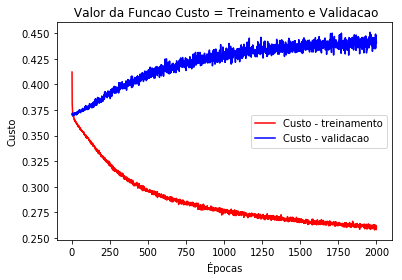

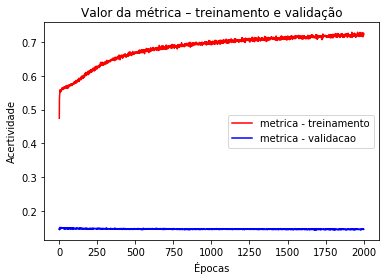

In [35]:
rna4.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna4.plot()

Confusion matrix, without normalization
[[9988  806]
 [1492 1523]]


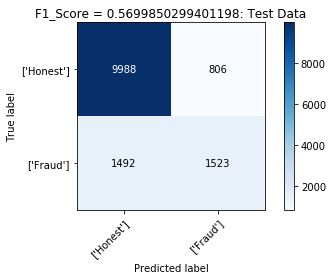

Confusion matrix, without normalization
[[9885  910]
 [1504 1511]]


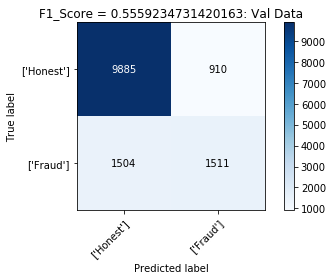

Confusion matrix, without normalization
[[49171  1201]
 [ 3364 10704]]


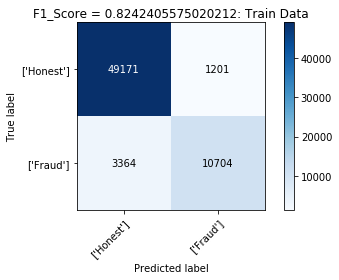

In [36]:
rna4.predict(x_data,y_data)

In [37]:
n_list5 = [100,100,100,1]
activation_list5 = ['tanh','tanh','tanh','sigmoid']
dropout_list5 = [0.3,0.3,0.3]

In [38]:
rna5 = new_rna()
rna5.build_model(data_shape,n_list5,activation_list5,dropout_list5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total para

Train on 64440 samples, validate on 13810 samples
Epoch 1/2000
64440/64440 [==============================] - 4s 66us/step - loss: 0.4125 - f1: 0.4699 - val_loss: 0.3681 - val_f1: 0.1462
Epoch 2/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.3784 - f1: 0.5332 - val_loss: 0.3693 - val_f1: 0.1448
Epoch 3/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.3739 - f1: 0.5394 - val_loss: 0.3699 - val_f1: 0.1492
Epoch 4/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.3714 - f1: 0.5468 - val_loss: 0.3689 - val_f1: 0.1448
Epoch 5/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.3698 - f1: 0.5454 - val_loss: 0.3694 - val_f1: 0.1486
Epoch 6/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.3689 - f1: 0.5533 - val_loss: 0.3688 - val_f1: 0.1481
Epoch 7/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.3679 - f1: 0.5512 - val_loss: 0.3684 - val_f1

64440/64440 [==============================] - 4s 58us/step - loss: 0.3525 - f1: 0.5672 - val_loss: 0.3723 - val_f1: 0.1455
Epoch 61/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.3524 - f1: 0.5701 - val_loss: 0.3724 - val_f1: 0.1449
Epoch 62/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.3517 - f1: 0.5709 - val_loss: 0.3736 - val_f1: 0.1464
Epoch 63/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.3525 - f1: 0.5683 - val_loss: 0.3732 - val_f1: 0.1468
Epoch 64/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.3526 - f1: 0.5709 - val_loss: 0.3733 - val_f1: 0.1464
Epoch 65/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.3518 - f1: 0.5654 - val_loss: 0.3732 - val_f1: 0.1470
Epoch 66/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.3521 - f1: 0.5680 - val_loss: 0.3725 - val_f1: 0.1470
Epoch 67/2000
64440/64440 [=====================

64440/64440 [==============================] - 4s 55us/step - loss: 0.3376 - f1: 0.5927 - val_loss: 0.3766 - val_f1: 0.1452
Epoch 120/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3371 - f1: 0.5928 - val_loss: 0.3809 - val_f1: 0.1458
Epoch 121/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.3376 - f1: 0.5861 - val_loss: 0.3774 - val_f1: 0.1455
Epoch 122/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3369 - f1: 0.5919 - val_loss: 0.3798 - val_f1: 0.1458
Epoch 123/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3384 - f1: 0.5906 - val_loss: 0.3772 - val_f1: 0.1448
Epoch 124/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3366 - f1: 0.5882 - val_loss: 0.3773 - val_f1: 0.1457
Epoch 125/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.3366 - f1: 0.5908 - val_loss: 0.3803 - val_f1: 0.1464
Epoch 126/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 57us/step - loss: 0.3182 - f1: 0.6233 - val_loss: 0.3885 - val_f1: 0.1445
Epoch 179/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3189 - f1: 0.6240 - val_loss: 0.3866 - val_f1: 0.1449
Epoch 180/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3191 - f1: 0.6236 - val_loss: 0.3856 - val_f1: 0.1448
Epoch 181/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.3173 - f1: 0.6287 - val_loss: 0.3854 - val_f1: 0.1461
Epoch 182/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.3179 - f1: 0.6252 - val_loss: 0.3850 - val_f1: 0.1457
Epoch 183/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.3169 - f1: 0.6286 - val_loss: 0.3898 - val_f1: 0.1450
Epoch 184/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.3177 - f1: 0.6232 - val_loss: 0.3872 - val_f1: 0.1446
Epoch 185/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 58us/step - loss: 0.2996 - f1: 0.6517 - val_loss: 0.4029 - val_f1: 0.1431
Epoch 238/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2993 - f1: 0.6561 - val_loss: 0.3972 - val_f1: 0.1437
Epoch 239/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2994 - f1: 0.6563 - val_loss: 0.4024 - val_f1: 0.1430
Epoch 240/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2988 - f1: 0.6567 - val_loss: 0.4084 - val_f1: 0.1444
Epoch 241/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2976 - f1: 0.6580 - val_loss: 0.3996 - val_f1: 0.1441
Epoch 242/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2983 - f1: 0.6541 - val_loss: 0.4036 - val_f1: 0.1438
Epoch 243/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2967 - f1: 0.6576 - val_loss: 0.4058 - val_f1: 0.1437
Epoch 244/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2820 - f1: 0.6832 - val_loss: 0.4183 - val_f1: 0.1417
Epoch 297/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2794 - f1: 0.6865 - val_loss: 0.4105 - val_f1: 0.1424
Epoch 298/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2824 - f1: 0.6788 - val_loss: 0.4155 - val_f1: 0.1423
Epoch 299/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2823 - f1: 0.6836 - val_loss: 0.4145 - val_f1: 0.1415
Epoch 300/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2804 - f1: 0.6863 - val_loss: 0.4110 - val_f1: 0.1415
Epoch 301/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2816 - f1: 0.6837 - val_loss: 0.4118 - val_f1: 0.1427
Epoch 302/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2810 - f1: 0.6850 - val_loss: 0.4109 - val_f1: 0.1423
Epoch 303/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2700 - f1: 0.6994 - val_loss: 0.4236 - val_f1: 0.1418
Epoch 356/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2689 - f1: 0.6973 - val_loss: 0.4197 - val_f1: 0.1421
Epoch 357/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2699 - f1: 0.7000 - val_loss: 0.4227 - val_f1: 0.1417
Epoch 358/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2697 - f1: 0.7001 - val_loss: 0.4237 - val_f1: 0.1411
Epoch 359/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2680 - f1: 0.7035 - val_loss: 0.4251 - val_f1: 0.1400
Epoch 360/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2690 - f1: 0.7027 - val_loss: 0.4244 - val_f1: 0.1407
Epoch 361/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2687 - f1: 0.7043 - val_loss: 0.4219 - val_f1: 0.1417
Epoch 362/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 57us/step - loss: 0.2554 - f1: 0.7222 - val_loss: 0.4440 - val_f1: 0.1400
Epoch 415/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2559 - f1: 0.7194 - val_loss: 0.4399 - val_f1: 0.1403
Epoch 416/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2575 - f1: 0.7159 - val_loss: 0.4326 - val_f1: 0.1408
Epoch 417/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2554 - f1: 0.7181 - val_loss: 0.4398 - val_f1: 0.1413
Epoch 418/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2568 - f1: 0.7198 - val_loss: 0.4277 - val_f1: 0.1411
Epoch 419/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2567 - f1: 0.7168 - val_loss: 0.4394 - val_f1: 0.1415
Epoch 420/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2562 - f1: 0.7186 - val_loss: 0.4354 - val_f1: 0.1413
Epoch 421/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2473 - f1: 0.7283 - val_loss: 0.4493 - val_f1: 0.1407
Epoch 474/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2451 - f1: 0.7326 - val_loss: 0.4465 - val_f1: 0.1400
Epoch 475/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2455 - f1: 0.7366 - val_loss: 0.4525 - val_f1: 0.1396
Epoch 476/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2471 - f1: 0.7283 - val_loss: 0.4446 - val_f1: 0.1394
Epoch 477/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2459 - f1: 0.7324 - val_loss: 0.4526 - val_f1: 0.1390
Epoch 478/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2484 - f1: 0.7269 - val_loss: 0.4442 - val_f1: 0.1403
Epoch 479/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2461 - f1: 0.7316 - val_loss: 0.4511 - val_f1: 0.1395
Epoch 480/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 57us/step - loss: 0.2387 - f1: 0.7416 - val_loss: 0.4610 - val_f1: 0.1382
Epoch 533/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2412 - f1: 0.7380 - val_loss: 0.4555 - val_f1: 0.1390
Epoch 534/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.2388 - f1: 0.7433 - val_loss: 0.4539 - val_f1: 0.1385
Epoch 535/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2372 - f1: 0.7466 - val_loss: 0.4603 - val_f1: 0.1385
Epoch 536/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2409 - f1: 0.7419 - val_loss: 0.4505 - val_f1: 0.1396
Epoch 537/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2406 - f1: 0.7412 - val_loss: 0.4572 - val_f1: 0.1398
Epoch 538/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2408 - f1: 0.7412 - val_loss: 0.4508 - val_f1: 0.1403
Epoch 539/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2333 - f1: 0.7494 - val_loss: 0.4656 - val_f1: 0.1395
Epoch 592/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2356 - f1: 0.7449 - val_loss: 0.4559 - val_f1: 0.1403
Epoch 593/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2348 - f1: 0.7506 - val_loss: 0.4604 - val_f1: 0.1392
Epoch 594/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2316 - f1: 0.7502 - val_loss: 0.4557 - val_f1: 0.1393
Epoch 595/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2320 - f1: 0.7500 - val_loss: 0.4626 - val_f1: 0.1400
Epoch 596/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2319 - f1: 0.7546 - val_loss: 0.4612 - val_f1: 0.1392
Epoch 597/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2332 - f1: 0.7503 - val_loss: 0.4612 - val_f1: 0.1393
Epoch 598/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2284 - f1: 0.7545 - val_loss: 0.4670 - val_f1: 0.1397
Epoch 651/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2269 - f1: 0.7571 - val_loss: 0.4671 - val_f1: 0.1409
Epoch 652/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2269 - f1: 0.7548 - val_loss: 0.4718 - val_f1: 0.1398
Epoch 653/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2266 - f1: 0.7592 - val_loss: 0.4744 - val_f1: 0.1395
Epoch 654/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2258 - f1: 0.7620 - val_loss: 0.4686 - val_f1: 0.1401
Epoch 655/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2274 - f1: 0.7564 - val_loss: 0.4785 - val_f1: 0.1394
Epoch 656/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2275 - f1: 0.7589 - val_loss: 0.4715 - val_f1: 0.1390
Epoch 657/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 60us/step - loss: 0.2196 - f1: 0.7688 - val_loss: 0.4774 - val_f1: 0.1394
Epoch 710/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2227 - f1: 0.7660 - val_loss: 0.4869 - val_f1: 0.1393
Epoch 711/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2233 - f1: 0.7642 - val_loss: 0.4770 - val_f1: 0.1394
Epoch 712/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2241 - f1: 0.7656 - val_loss: 0.4794 - val_f1: 0.1394
Epoch 713/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.2224 - f1: 0.7645 - val_loss: 0.4793 - val_f1: 0.1401
Epoch 714/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.2204 - f1: 0.7655 - val_loss: 0.4832 - val_f1: 0.1399
Epoch 715/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2218 - f1: 0.7637 - val_loss: 0.4760 - val_f1: 0.1414
Epoch 716/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2186 - f1: 0.7696 - val_loss: 0.4729 - val_f1: 0.1387
Epoch 769/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.2166 - f1: 0.7723 - val_loss: 0.4832 - val_f1: 0.1401
Epoch 770/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2190 - f1: 0.7644 - val_loss: 0.4801 - val_f1: 0.1393
Epoch 771/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2188 - f1: 0.7676 - val_loss: 0.4849 - val_f1: 0.1406
Epoch 772/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2177 - f1: 0.7709 - val_loss: 0.4783 - val_f1: 0.1400
Epoch 773/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.2165 - f1: 0.7735 - val_loss: 0.4893 - val_f1: 0.1392
Epoch 774/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2192 - f1: 0.7666 - val_loss: 0.4844 - val_f1: 0.1400
Epoch 775/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2140 - f1: 0.7721 - val_loss: 0.4904 - val_f1: 0.1398
Epoch 828/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2135 - f1: 0.7791 - val_loss: 0.4891 - val_f1: 0.1392
Epoch 829/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.2125 - f1: 0.7717 - val_loss: 0.4961 - val_f1: 0.1393
Epoch 830/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2113 - f1: 0.7810 - val_loss: 0.4983 - val_f1: 0.1395
Epoch 831/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2146 - f1: 0.7731 - val_loss: 0.4960 - val_f1: 0.1384
Epoch 832/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2153 - f1: 0.7717 - val_loss: 0.4924 - val_f1: 0.1388
Epoch 833/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2123 - f1: 0.7744 - val_loss: 0.4918 - val_f1: 0.1391
Epoch 834/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 57us/step - loss: 0.2121 - f1: 0.7732 - val_loss: 0.4943 - val_f1: 0.1393
Epoch 887/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2117 - f1: 0.7777 - val_loss: 0.4990 - val_f1: 0.1393
Epoch 888/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2097 - f1: 0.7797 - val_loss: 0.4884 - val_f1: 0.1383
Epoch 889/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2091 - f1: 0.7752 - val_loss: 0.5015 - val_f1: 0.1389
Epoch 890/2000
64440/64440 [==============================] - 4s 55us/step - loss: 0.2098 - f1: 0.7781 - val_loss: 0.5066 - val_f1: 0.1395
Epoch 891/2000
64440/64440 [==============================] - 3s 52us/step - loss: 0.2108 - f1: 0.7784 - val_loss: 0.4960 - val_f1: 0.1395
Epoch 892/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2117 - f1: 0.7776 - val_loss: 0.4947 - val_f1: 0.1388
Epoch 893/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2078 - f1: 0.7835 - val_loss: 0.5024 - val_f1: 0.1378
Epoch 946/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2063 - f1: 0.7838 - val_loss: 0.4997 - val_f1: 0.1394
Epoch 947/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2069 - f1: 0.7809 - val_loss: 0.4983 - val_f1: 0.1389
Epoch 948/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2092 - f1: 0.7785 - val_loss: 0.4901 - val_f1: 0.1387
Epoch 949/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.2079 - f1: 0.7818 - val_loss: 0.5044 - val_f1: 0.1386
Epoch 950/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2065 - f1: 0.7859 - val_loss: 0.5082 - val_f1: 0.1385
Epoch 951/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2062 - f1: 0.7888 - val_loss: 0.4893 - val_f1: 0.1395
Epoch 952/2000
64440/64440 [==============

64440/64440 [==============================] - 4s 56us/step - loss: 0.2031 - f1: 0.7894 - val_loss: 0.5087 - val_f1: 0.1384
Epoch 1005/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2036 - f1: 0.7870 - val_loss: 0.4963 - val_f1: 0.1384
Epoch 1006/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.2061 - f1: 0.7851 - val_loss: 0.4980 - val_f1: 0.1379
Epoch 1007/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2063 - f1: 0.7822 - val_loss: 0.4976 - val_f1: 0.1383
Epoch 1008/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2049 - f1: 0.7856 - val_loss: 0.5007 - val_f1: 0.1386
Epoch 1009/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2075 - f1: 0.7817 - val_loss: 0.5053 - val_f1: 0.1389
Epoch 1010/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2060 - f1: 0.7850 - val_loss: 0.5022 - val_f1: 0.1392
Epoch 1011/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 60us/step - loss: 0.2048 - f1: 0.7857 - val_loss: 0.5116 - val_f1: 0.1386
Epoch 1063/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2024 - f1: 0.7875 - val_loss: 0.5032 - val_f1: 0.1387
Epoch 1064/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2033 - f1: 0.7861 - val_loss: 0.5187 - val_f1: 0.1387
Epoch 1065/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2031 - f1: 0.7856 - val_loss: 0.5027 - val_f1: 0.1387
Epoch 1066/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.2029 - f1: 0.7880 - val_loss: 0.5042 - val_f1: 0.1381
Epoch 1067/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2014 - f1: 0.7913 - val_loss: 0.5069 - val_f1: 0.1379
Epoch 1068/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2001 - f1: 0.7935 - val_loss: 0.5072 - val_f1: 0.1375
Epoch 1069/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 58us/step - loss: 0.1978 - f1: 0.7967 - val_loss: 0.5177 - val_f1: 0.1376
Epoch 1121/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.1988 - f1: 0.7933 - val_loss: 0.5158 - val_f1: 0.1387
Epoch 1122/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2021 - f1: 0.7897 - val_loss: 0.5151 - val_f1: 0.1380
Epoch 1123/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2019 - f1: 0.7881 - val_loss: 0.5066 - val_f1: 0.1379
Epoch 1124/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1999 - f1: 0.7882 - val_loss: 0.5133 - val_f1: 0.1385
Epoch 1125/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2000 - f1: 0.7907 - val_loss: 0.5102 - val_f1: 0.1375
Epoch 1126/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.2014 - f1: 0.7927 - val_loss: 0.5152 - val_f1: 0.1379
Epoch 1127/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1978 - f1: 0.7929 - val_loss: 0.5116 - val_f1: 0.1382
Epoch 1179/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2003 - f1: 0.7916 - val_loss: 0.5104 - val_f1: 0.1369
Epoch 1180/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.1976 - f1: 0.7953 - val_loss: 0.5106 - val_f1: 0.1390
Epoch 1181/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1980 - f1: 0.7933 - val_loss: 0.5154 - val_f1: 0.1377
Epoch 1182/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1967 - f1: 0.7931 - val_loss: 0.5128 - val_f1: 0.1382
Epoch 1183/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1967 - f1: 0.7979 - val_loss: 0.5224 - val_f1: 0.1393
Epoch 1184/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.2002 - f1: 0.7930 - val_loss: 0.5162 - val_f1: 0.1384
Epoch 1185/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 61us/step - loss: 0.1960 - f1: 0.7966 - val_loss: 0.5090 - val_f1: 0.1396
Epoch 1237/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1977 - f1: 0.7946 - val_loss: 0.5226 - val_f1: 0.1380
Epoch 1238/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1948 - f1: 0.7981 - val_loss: 0.5113 - val_f1: 0.1379
Epoch 1239/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1956 - f1: 0.7952 - val_loss: 0.5251 - val_f1: 0.1381
Epoch 1240/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1979 - f1: 0.7947 - val_loss: 0.5246 - val_f1: 0.1385
Epoch 1241/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1952 - f1: 0.7978 - val_loss: 0.5137 - val_f1: 0.1393
Epoch 1242/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1952 - f1: 0.7970 - val_loss: 0.5178 - val_f1: 0.1381
Epoch 1243/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 58us/step - loss: 0.1933 - f1: 0.8009 - val_loss: 0.5177 - val_f1: 0.1380
Epoch 1295/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.1923 - f1: 0.8026 - val_loss: 0.5281 - val_f1: 0.1370
Epoch 1296/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1937 - f1: 0.8030 - val_loss: 0.5177 - val_f1: 0.1378
Epoch 1297/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1940 - f1: 0.8013 - val_loss: 0.5298 - val_f1: 0.1388
Epoch 1298/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1936 - f1: 0.7988 - val_loss: 0.5222 - val_f1: 0.1382
Epoch 1299/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1979 - f1: 0.7924 - val_loss: 0.5176 - val_f1: 0.1384
Epoch 1300/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1941 - f1: 0.7926 - val_loss: 0.5272 - val_f1: 0.1389
Epoch 1301/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 56us/step - loss: 0.1923 - f1: 0.8022 - val_loss: 0.5196 - val_f1: 0.1384
Epoch 1353/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1922 - f1: 0.8035 - val_loss: 0.5285 - val_f1: 0.1382
Epoch 1354/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1927 - f1: 0.7999 - val_loss: 0.5301 - val_f1: 0.1389
Epoch 1355/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1944 - f1: 0.8023 - val_loss: 0.5296 - val_f1: 0.1385
Epoch 1356/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1934 - f1: 0.8017 - val_loss: 0.5318 - val_f1: 0.1371
Epoch 1357/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.1912 - f1: 0.7995 - val_loss: 0.5270 - val_f1: 0.1380
Epoch 1358/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1921 - f1: 0.8016 - val_loss: 0.5207 - val_f1: 0.1382
Epoch 1359/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 60us/step - loss: 0.1912 - f1: 0.8032 - val_loss: 0.5155 - val_f1: 0.1380
Epoch 1411/2000
64440/64440 [==============================] - 4s 56us/step - loss: 0.1910 - f1: 0.8015 - val_loss: 0.5225 - val_f1: 0.1375
Epoch 1412/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1914 - f1: 0.8016 - val_loss: 0.5395 - val_f1: 0.1371
Epoch 1413/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1890 - f1: 0.8064 - val_loss: 0.5216 - val_f1: 0.1383
Epoch 1414/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.1888 - f1: 0.8074 - val_loss: 0.5272 - val_f1: 0.1377
Epoch 1415/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1909 - f1: 0.8053 - val_loss: 0.5187 - val_f1: 0.1368
Epoch 1416/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1909 - f1: 0.8035 - val_loss: 0.5253 - val_f1: 0.1375
Epoch 1417/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1900 - f1: 0.8035 - val_loss: 0.5150 - val_f1: 0.1372
Epoch 1469/2000
64440/64440 [==============================] - 4s 62us/step - loss: 0.1876 - f1: 0.8062 - val_loss: 0.5224 - val_f1: 0.1378
Epoch 1470/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1894 - f1: 0.8014 - val_loss: 0.5297 - val_f1: 0.1375
Epoch 1471/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1885 - f1: 0.8032 - val_loss: 0.5316 - val_f1: 0.1368
Epoch 1472/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1888 - f1: 0.8069 - val_loss: 0.5326 - val_f1: 0.1379
Epoch 1473/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.1880 - f1: 0.8081 - val_loss: 0.5226 - val_f1: 0.1387
Epoch 1474/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1909 - f1: 0.7983 - val_loss: 0.5297 - val_f1: 0.1385
Epoch 1475/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1876 - f1: 0.8038 - val_loss: 0.5259 - val_f1: 0.1386
Epoch 1527/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1887 - f1: 0.8052 - val_loss: 0.5195 - val_f1: 0.1382
Epoch 1528/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1851 - f1: 0.8117 - val_loss: 0.5262 - val_f1: 0.1395
Epoch 1529/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1871 - f1: 0.8089 - val_loss: 0.5305 - val_f1: 0.1380
Epoch 1530/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1873 - f1: 0.8074 - val_loss: 0.5370 - val_f1: 0.1391
Epoch 1531/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1871 - f1: 0.8073 - val_loss: 0.5197 - val_f1: 0.1378
Epoch 1532/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1875 - f1: 0.8071 - val_loss: 0.5193 - val_f1: 0.1379
Epoch 1533/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 60us/step - loss: 0.1860 - f1: 0.8061 - val_loss: 0.5273 - val_f1: 0.1376
Epoch 1585/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1869 - f1: 0.8067 - val_loss: 0.5275 - val_f1: 0.1377
Epoch 1586/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1857 - f1: 0.8105 - val_loss: 0.5394 - val_f1: 0.1382
Epoch 1587/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1845 - f1: 0.8091 - val_loss: 0.5410 - val_f1: 0.1376
Epoch 1588/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1859 - f1: 0.8101 - val_loss: 0.5239 - val_f1: 0.1383
Epoch 1589/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1856 - f1: 0.8073 - val_loss: 0.5394 - val_f1: 0.1378
Epoch 1590/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1889 - f1: 0.8048 - val_loss: 0.5347 - val_f1: 0.1388
Epoch 1591/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1851 - f1: 0.8057 - val_loss: 0.5298 - val_f1: 0.1380
Epoch 1643/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1834 - f1: 0.8165 - val_loss: 0.5297 - val_f1: 0.1382
Epoch 1644/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1836 - f1: 0.8107 - val_loss: 0.5314 - val_f1: 0.1385
Epoch 1645/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1851 - f1: 0.8086 - val_loss: 0.5380 - val_f1: 0.1381
Epoch 1646/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.1850 - f1: 0.8111 - val_loss: 0.5268 - val_f1: 0.1384
Epoch 1647/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1854 - f1: 0.8079 - val_loss: 0.5229 - val_f1: 0.1381
Epoch 1648/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1861 - f1: 0.8094 - val_loss: 0.5337 - val_f1: 0.1380
Epoch 1649/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1842 - f1: 0.8111 - val_loss: 0.5327 - val_f1: 0.1383
Epoch 1701/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1820 - f1: 0.8133 - val_loss: 0.5315 - val_f1: 0.1389
Epoch 1702/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1823 - f1: 0.8144 - val_loss: 0.5261 - val_f1: 0.1377
Epoch 1703/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1861 - f1: 0.8097 - val_loss: 0.5304 - val_f1: 0.1379
Epoch 1704/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1856 - f1: 0.8106 - val_loss: 0.5215 - val_f1: 0.1383
Epoch 1705/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1850 - f1: 0.8073 - val_loss: 0.5328 - val_f1: 0.1378
Epoch 1706/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1843 - f1: 0.8111 - val_loss: 0.5352 - val_f1: 0.1378
Epoch 1707/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 61us/step - loss: 0.1816 - f1: 0.8134 - val_loss: 0.5374 - val_f1: 0.1388
Epoch 1759/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1817 - f1: 0.8141 - val_loss: 0.5285 - val_f1: 0.1384
Epoch 1760/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1814 - f1: 0.8115 - val_loss: 0.5250 - val_f1: 0.1385
Epoch 1761/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1841 - f1: 0.8104 - val_loss: 0.5425 - val_f1: 0.1377
Epoch 1762/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.1824 - f1: 0.8111 - val_loss: 0.5267 - val_f1: 0.1377
Epoch 1763/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1837 - f1: 0.8127 - val_loss: 0.5347 - val_f1: 0.1383
Epoch 1764/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1841 - f1: 0.8085 - val_loss: 0.5278 - val_f1: 0.1381
Epoch 1765/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1819 - f1: 0.8160 - val_loss: 0.5306 - val_f1: 0.1383
Epoch 1817/2000
64440/64440 [==============================] - 3s 54us/step - loss: 0.1810 - f1: 0.8173 - val_loss: 0.5362 - val_f1: 0.1382
Epoch 1818/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1846 - f1: 0.8082 - val_loss: 0.5376 - val_f1: 0.1391
Epoch 1819/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1820 - f1: 0.8116 - val_loss: 0.5366 - val_f1: 0.1387
Epoch 1820/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1800 - f1: 0.8160 - val_loss: 0.5442 - val_f1: 0.1380
Epoch 1821/2000
64440/64440 [==============================] - 4s 59us/step - loss: 0.1830 - f1: 0.8121 - val_loss: 0.5378 - val_f1: 0.1386
Epoch 1822/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1791 - f1: 0.8196 - val_loss: 0.5429 - val_f1: 0.1374
Epoch 1823/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1813 - f1: 0.8158 - val_loss: 0.5332 - val_f1: 0.1378
Epoch 1875/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1827 - f1: 0.8089 - val_loss: 0.5402 - val_f1: 0.1382
Epoch 1876/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1825 - f1: 0.8099 - val_loss: 0.5394 - val_f1: 0.1382
Epoch 1877/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1816 - f1: 0.8118 - val_loss: 0.5388 - val_f1: 0.1383
Epoch 1878/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1812 - f1: 0.8187 - val_loss: 0.5381 - val_f1: 0.1380
Epoch 1879/2000
64440/64440 [==============================] - 4s 58us/step - loss: 0.1807 - f1: 0.8173 - val_loss: 0.5393 - val_f1: 0.1378
Epoch 1880/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1830 - f1: 0.8138 - val_loss: 0.5333 - val_f1: 0.1382
Epoch 1881/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 58us/step - loss: 0.1778 - f1: 0.8179 - val_loss: 0.5407 - val_f1: 0.1374
Epoch 1933/2000
64440/64440 [==============================] - 4s 61us/step - loss: 0.1787 - f1: 0.8184 - val_loss: 0.5399 - val_f1: 0.1378
Epoch 1934/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1799 - f1: 0.8148 - val_loss: 0.5348 - val_f1: 0.1377
Epoch 1935/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1793 - f1: 0.8160 - val_loss: 0.5428 - val_f1: 0.1380
Epoch 1936/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1785 - f1: 0.8169 - val_loss: 0.5494 - val_f1: 0.1375
Epoch 1937/2000
64440/64440 [==============================] - 4s 60us/step - loss: 0.1795 - f1: 0.8155 - val_loss: 0.5461 - val_f1: 0.1381
Epoch 1938/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1794 - f1: 0.8154 - val_loss: 0.5516 - val_f1: 0.1377
Epoch 1939/2000
64440/64440 [=======

64440/64440 [==============================] - 4s 57us/step - loss: 0.1784 - f1: 0.8165 - val_loss: 0.5428 - val_f1: 0.1373
Epoch 1991/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1794 - f1: 0.8175 - val_loss: 0.5495 - val_f1: 0.1375
Epoch 1992/2000
64440/64440 [==============================] - 4s 62us/step - loss: 0.1773 - f1: 0.8194 - val_loss: 0.5445 - val_f1: 0.1380
Epoch 1993/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1786 - f1: 0.8168 - val_loss: 0.5342 - val_f1: 0.1386
Epoch 1994/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1763 - f1: 0.8194 - val_loss: 0.5536 - val_f1: 0.1380
Epoch 1995/2000
64440/64440 [==============================] - 4s 57us/step - loss: 0.1794 - f1: 0.8176 - val_loss: 0.5392 - val_f1: 0.1375
Epoch 1996/2000
64440/64440 [==============================] - 4s 62us/step - loss: 0.1781 - f1: 0.8166 - val_loss: 0.5395 - val_f1: 0.1378
Epoch 1997/2000
64440/64440 [=======

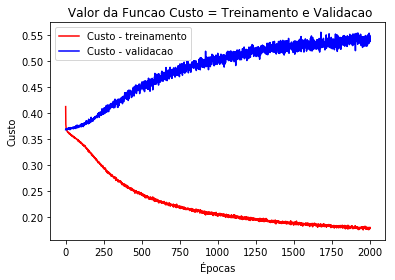

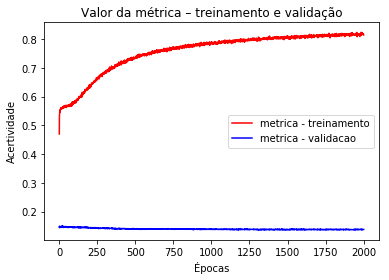

In [39]:
rna5.train(x_train_norm,y_train,x_val_norm,y_val,batch_size,epochs,loss,metric)
rna5.plot()

Confusion matrix, without normalization
[[10027   767]
 [ 1577  1438]]


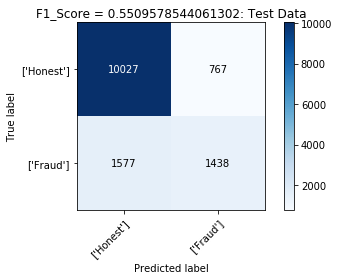

Confusion matrix, without normalization
[[9989  806]
 [1614 1401]]


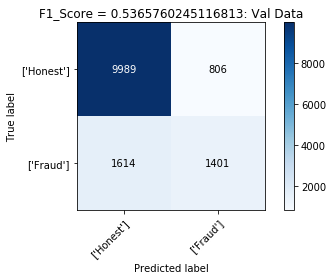

Confusion matrix, without normalization
[[50203   169]
 [ 1277 12791]]


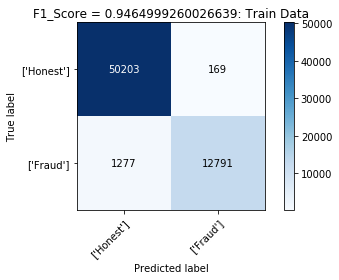

In [40]:
rna5.predict(x_data,y_data)